In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, constants as cnst, u_arrays, u_darrays
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.io.shapereader as shapereader
from utils import u_statistics as u_stat
from scipy.stats import norm
import matplotlib.mlab as mlab
from wavelet import util, wav
import glob

coast = shapereader.natural_earth(resolution='110m',
                                  category='physical',
                                  name='coastline')

countries = shapereader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
tables = glob.glob('/media/ck/Elements/Africa/WestAfrica/NFLICS/tables/blob_bigDomain_allscales_-40_9-130km_points_dominant_daily_NFLICSdomain_*.csv')

In [4]:
tab = pd.read_table(tables[0], parse_dates=True, delimiter=',')

In [5]:
tab

id                 date        lon        lat  hour  month  year  \
0        0  2004-06-01 14:00:00  -4.471372  12.713856    14      6  2004   
1        1  2004-06-01 15:00:00  -5.441552   9.547217    15      6  2004   
2        2  2004-06-01 15:00:00  -7.058520  10.001661    15      6  2004   
3        3  2004-06-01 15:00:00  -8.864134   9.038582    15      6  2004   
4        4  2004-06-01 15:00:00  -7.139368   9.359912    15      6  2004   
...    ...                  ...        ...        ...   ...    ...   ...   
5929  5929  2004-06-30 23:00:00 -11.801625  11.918905    23      6  2004   
5930  5930  2004-06-30 23:00:00 -11.990271  11.945443    23      6  2004   
5931  5931  2004-06-30 23:00:00 -11.855523  11.945443    23      6  2004   
5932  5932  2004-06-30 23:00:00  -9.699567  13.638112    23      6  2004   
5933  5933  2004-06-30 23:00:00  -9.052780  15.109240    23      6  2004   

      core_scale    tir  
0              9 -74.33  
1             24 -74.90  
2              9 -77.23  
3             24 -76.54  
4             13 -75.34  
...          ...    ...  
5929          66 -71.00  
5930           9 -73.66  
5931          48 -71.66  
5932          92 -89.61  
5933          13 -78.00  

[5934 rows x 9 columns]

In [8]:
for t in tables:
    dummy = pd.read_table(t, parse_dates=True, delimiter=',') 
    tab = pd.concat([tab, dummy], axis=0)

In [9]:
tab.date

0        2004-06-01 14:00:00
1        2004-06-01 15:00:00
2        2004-06-01 15:00:00
3        2004-06-01 15:00:00
4        2004-06-01 15:00:00
                ...         
11795    2012-08-31 23:00:00
11796    2012-08-31 23:00:00
11797    2012-08-31 23:00:00
11798    2012-08-31 23:00:00
11799    2012-08-31 23:00:00
Name: date, Length: 612601, dtype: object

In [10]:
print(np.min(tab.lon), np.max(tab.lon),np.min(tab.lat),np.max(tab.lat),)

-16.975920576103743 -0.024711164768374736 9.011791506063838 19.968051086175453


In [11]:
alldates = []
for dat in tab.date:
    alldates.append((dat)[0:-9])

In [12]:
inddates = np.unique(alldates)

In [35]:
tab = tab[tab.hour==17]

In [36]:
tab[0:10]

id                 date       lon        lat  hour  month  year  \
29  29  2004-06-01 17:00:00 -8.998881   9.011792    17      6  2004   
30  30  2004-06-01 17:00:00 -8.486841   9.118942    17      6  2004   
31  31  2004-06-01 17:00:00 -6.869874   9.118942    17      6  2004   
32  32  2004-06-01 17:00:00 -7.705307   9.359912    17      6  2004   
33  33  2004-06-01 17:00:00 -8.810235   9.466956    17      6  2004   
34  34  2004-06-01 17:00:00 -8.190397   9.466956    17      6  2004   
35  35  2004-06-01 17:00:00 -7.920903   9.868066    17      6  2004   
36  36  2004-06-01 17:00:00 -7.786155  10.295372    17      6  2004   
37  37  2004-06-01 17:00:00 -5.549350  11.440791    17      6  2004   
38  38  2004-06-01 17:00:00 -4.390523  11.839278    17      6  2004   

    core_scale    tir  
29          48 -75.00  
30          34 -76.00  
31          13 -75.33  
32           9 -87.61  
33          18 -83.17  
34           9 -75.56  
35           9 -83.27  
36          92 -90.74  
37          24 -81.03  
38          13 -81.50

In [37]:
def cut_kernel(xpos, ypos, arr, date, lon, lat):

    #AMSRE 0.25 degrees ~ 27.5 km
    dist = 100

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)


    # if (np.sum(np.isfinite(kernel)) < 0.10 * kernel.size):
    #     return

    kernel3 = kernel - np.nanmean(kernel)

    cnt = np.zeros_like(kernel)
    cnt[np.isfinite(kernel)] = 1

    if kernel.shape != (dist*2+1, dist*2+1):
        return None

    return kernel, kernel3, cnt

In [38]:
def run(shift):

    kernel2_list = []
    kernel3_list = []
    cnt_list = []


    for date in np.unique(tab.date)[0:100]:


        single = tab[tab.date==date]


        dt = pd.to_datetime(date)
        
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd

        #ipdb.set_trace()
        fdate = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2)

        lpath = cnst.elements_drive+'/Africa/WestAfrica/NFLICS/LSTA_2004-2015/netcdf_onCores/'

        try:
            #ipdb.set_trace()
            lsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_' + fdate + '1700.nc') #sma  #'AMSR_L3_LPRMv05_A_'

        except:
            print('Could not find '+fdate)
            continue
        
        print('Doing', date)
        for index, row in single.iterrows():



    #         testbox = lsta['lsta'].sel(lon=slice(-20, 15), lat=slice(4, 25)).values

    #         if np.isnan(testbox).all():
    #                 print('Testbox empty')
    #                 continue
 
            #lsta = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day))


            lsta_da = (lsta['lsta'].squeeze())/100
            lsta_da.values[lsta_da.values==0]=np.nan
        #     booleans = np.zeros_like(lsta_da.values) * np.nan
        #     booleans[lsta_da.values>4] = 1
        #     booleans[lsta_da.values<-4] = -1

            #lsta_da.values = booleans


            point = lsta_da.sel(lat=row.lat, lon=row.lon, method='nearest')
        #     if np.isnan(point.values):
        #         continue


#             print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
#             dt.day).zfill(2) + '.nc')
            plat = point['lat'].values
            plon = point['lon'].values

            xpos = np.where(lsta_da['lon'].values == plon)
            xpos = int(xpos[0])
            ypos = np.where(lsta_da['lat'].values == plat)
            ypos = int(ypos[0])


            try:
                rkernel2, rkernel3, rcnt = cut_kernel(xpos, ypos, lsta_da, dt, plon, plat)
            except TypeError:
                continue

#             cnt = np.zeros_like(lsta_da.values)
#             cnt[np.isfinite(lsta_da.values)] = 1

            kernel2_list.append(rkernel2)
            kernel3_list.append(rkernel3)
            cnt_list.append(rcnt) 

            lat = lsta.lat.values
            lon = lsta.lon.values
        del lsta
    kernel2_sum = np.nansum(np.stack(kernel2_list, axis=0), axis=0)
    kernel3_sum = np.nansum(np.stack(kernel3_list, axis=0), axis=0)
    cnt_sum = np.nansum(np.stack(cnt_list, axis=0), axis=0)
    return kernel2_sum, kernel3_sum, cnt_sum, lsta_da

In [51]:
ano, regional,cnt, da = run(1)

Doing 2004-06-01 17:00:00
Doing 2004-06-02 17:00:00
Doing 2004-06-03 17:00:00
Doing 2004-06-04 17:00:00
Doing 2004-06-05 17:00:00
Doing 2004-06-06 17:00:00
Doing 2004-06-07 17:00:00
Doing 2004-06-08 17:00:00
Doing 2004-06-09 17:00:00
Doing 2004-06-10 17:00:00
Doing 2004-06-11 17:00:00
Doing 2004-06-12 17:00:00
Doing 2004-06-13 17:00:00
Doing 2004-06-14 17:00:00
Doing 2004-06-15 17:00:00
Doing 2004-06-16 17:00:00
Doing 2004-06-17 17:00:00
Doing 2004-06-18 17:00:00
Doing 2004-06-19 17:00:00
Doing 2004-06-20 17:00:00
Doing 2004-06-21 17:00:00
Doing 2004-06-22 17:00:00
Doing 2004-06-23 17:00:00
Doing 2004-06-24 17:00:00
Doing 2004-06-25 17:00:00
Doing 2004-06-26 17:00:00
Doing 2004-06-27 17:00:00
Doing 2004-06-28 17:00:00
Doing 2004-06-29 17:00:00
Doing 2004-06-30 17:00:00
Doing 2004-07-01 17:00:00
Doing 2004-07-02 17:00:00
Doing 2004-07-03 17:00:00
Doing 2004-07-04 17:00:00
Doing 2004-07-05 17:00:00
Doing 2004-07-06 17:00:00
Doing 2004-07-07 17:00:00
Doing 2004-07-08 17:00:00
Doing 2004-0

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


Doing 2004-07-24 17:00:00
Doing 2004-07-25 17:00:00
Doing 2004-07-26 17:00:00
Doing 2004-07-27 17:00:00
Doing 2004-07-28 17:00:00
Doing 2004-07-29 17:00:00
Doing 2004-07-30 17:00:00
Doing 2004-07-31 17:00:00
Doing 2004-08-01 17:00:00
Doing 2004-08-02 17:00:00
Doing 2004-08-03 17:00:00
Doing 2004-08-04 17:00:00
Doing 2004-08-05 17:00:00
Doing 2004-08-06 17:00:00
Doing 2004-08-07 17:00:00
Doing 2004-08-08 17:00:00
Doing 2004-08-09 17:00:00
Doing 2004-08-10 17:00:00
Doing 2004-08-11 17:00:00
Doing 2004-08-12 17:00:00
Doing 2004-08-13 17:00:00
Doing 2004-08-14 17:00:00
Doing 2004-08-15 17:00:00
Doing 2004-08-16 17:00:00
Doing 2004-08-17 17:00:00
Doing 2004-08-18 17:00:00
Doing 2004-08-19 17:00:00
Doing 2004-08-20 17:00:00
Doing 2004-08-21 17:00:00
Doing 2004-08-22 17:00:00
Doing 2004-08-23 17:00:00
Doing 2004-08-24 17:00:00
Doing 2004-08-25 17:00:00
Doing 2004-08-26 17:00:00
Doing 2004-08-27 17:00:00
Doing 2004-08-28 17:00:00
Doing 2004-08-29 17:00:00
Doing 2004-08-30 17:00:00
Doing 2004-0

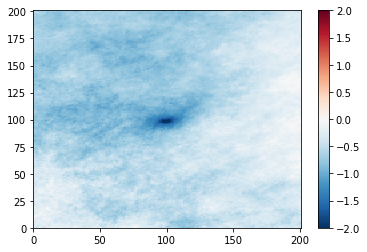

In [52]:
plt.pcolormesh(ano/cnt, cmap='RdBu_r', vmin=-2, vmax=2)
plt.colorbar()

In [47]:
def draw_map(ax, t, lat, lon, title=''):
   
    plt.contourf(lon-0.3, lat, t, transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=np.linspace(-2,2,6), extend='both')
    ax.coastlines()
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label('T anomaly (K)')

In [53]:
def cut_kernel_lsta(xpos, ypos, arr):

    dist=200

    kernel = u_arrays.cut_kernel(arr,xpos, ypos,dist)

    if (np.sum(np.isfinite(kernel)) < 0.01 * kernel.size):
        return

    kmean = kernel

    if kernel.shape != (2*dist+1, 2*dist+1):
        print('WRONG SHAPE')
        return
    ycirc30, xcirc30 = u_arrays.draw_circle(dist+1, dist+1,6) # 15km radius
    k30 = np.nanmean(kmean[ycirc30, xcirc30])

    ycirc100e, xcirc100e = u_arrays.draw_circle(dist+51, dist+1, 17)  # at - 150km, draw 50km radius circle
    #data = kmean[ycirc100e,xcirc100e]
    data = kernel[dist - 10:dist + 10, dist:dist + 67]

    e100 = np.nanmean(data)

    if (np.sum(np.isfinite(data)) / data.size) < 0.01:
        print('Too small valid area')
        return
    
    if np.isnan(e100):
        print('Is nan')
        return

    return k30, e100

In [57]:
tab

id                 date        lon        lat  hour  month  year  \
29        29  2004-06-01 17:00:00  -8.998881   9.011792    17      6  2004   
30        30  2004-06-01 17:00:00  -8.486841   9.118942    17      6  2004   
31        31  2004-06-01 17:00:00  -6.869874   9.118942    17      6  2004   
32        32  2004-06-01 17:00:00  -7.705307   9.359912    17      6  2004   
33        33  2004-06-01 17:00:00  -8.810235   9.466956    17      6  2004   
...      ...                  ...        ...        ...   ...    ...   ...   
11588  11588  2012-08-31 17:00:00  -6.842924  17.994071    17      8  2012   
11589  11589  2012-08-31 17:00:00  -6.681227  18.406180    17      8  2012   
11590  11590  2012-08-31 17:00:00 -11.316534  18.817294    17      8  2012   
11591  11591  2012-08-31 17:00:00  -4.255776  18.945560    17      8  2012   
11592  11592  2012-08-31 17:00:00  -8.675487  19.610923    17      8  2012   

       core_scale    tir  
29             48 -75.00  
30             34 -76.00  
31             13 -75.33  
32              9 -87.61  
33             18 -83.17  
...           ...    ...  
11588          18 -76.26  
11589           9 -77.06  
11590          24 -76.37  
11591          48 -75.00  
11592          34 -82.66  

[49172 rows x 9 columns]

In [58]:
kernel2_list = []
kernel3_list = []
cnt_list = []

amsrk30 = []
amsre100 = []

ramsrk30 = []
ramsre100 = []
   

for date in np.unique(tab.date):


        single = tab[tab.date==date]


        dt = pd.to_datetime(date)
        
#         daystring = str(abs(shift))
#         dayd = pd.Timedelta(daystring + 'days')
#         if shift < 0:
#             dt = dt - dayd
#         if shift >=0:
#             dt = dt + dayd


        fdate = str(dt.year) + str(dt.month).zfill(2) + str(dt.day).zfill(2)

        lpath = cnst.elements_drive+'/Africa/WestAfrica/NFLICS/LSTA_2004-2015/netcdf_onCores/'

        try:
            #ipdb.set_trace()
            lsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_' + fdate + '1700.nc') #sma  #'AMSR_L3_LPRMv05_A_'

        except:
            print('Could not find '+fdate)
            continue
        
        print('Doing', date)
        for index, row in single.iterrows():


            lsta_da = (lsta['lsta'].squeeze())/100
            lsta_da.values[lsta_da.values==0]=np.nan



            print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
            dt.day).zfill(2) + '.nc')



            point = lsta_da.sel(lat=row.lat, lon=row.lon, method='nearest')

            plat = point['lat'].values
            plon = point['lon'].values

            xpos = np.where(lsta_da['lon'].values == plon)
            xpos = int(xpos[0])
            ypos = np.where(lsta_da['lat'].values == plat)
            ypos = int(ypos[0])


            try:
                ak30, ae100 = cut_kernel_lsta(xpos, ypos, lsta_da.values)
            except TypeError:
                print('AMSR kernel error')
                continue


            amsrk30.append(ak30)
            amsre100.append(ae100)


            ##### random

            y = ypos
            x = xpos

            rdist = 50
            randy50 = [y - rdist, y - rdist, y - rdist, y, y, y + rdist, y + rdist, y + rdist]
            randx50 = [x - rdist, x, x + rdist, x - rdist, x + rdist, x - rdist, x, x + rdist]
            randy50_100 = [y - rdist, y - rdist, y, y, y + rdist, y + rdist]

            rdist = 100
            randx100 = [x - rdist, x + rdist, x - rdist, x + rdist, x - rdist, x + rdist]

            rdist = 150
            randx150 = [x - rdist, x + rdist, x - rdist, x + rdist, x - rdist, x + rdist]

            randy = np.array(randy50 + randy50_100 + randy50_100)
            randx = np.array(randx50 + randx100 + randx150)

            for ry, rx in zip(randy,randx):

                if ry < 0:
                    continue
                if ry > lsta_da.shape[0] - 1:
                    continue

                if rx < 0:
                    continue
                if rx > lsta_da.shape[1] - 1:
                    continue

                try:
                    lat = lsta_da['lat'][ry]
                except IndexError:
                    ipdb.set_trace()
                try:
                    lon = lsta_da['lon'][rx]
                except IndexError:
                    ipdb.set_trace()
                try:
                    point = lsta_da.sel(lat=lat, lon=lon, method='nearest', tolerance=0.03)
                except KeyError:
                    print('Nearest point finding error')
                    continue
                plat = point['lat'].values
                plon = point['lon'].values

                xpos = np.where(lsta_da['lon'].values == plon)
                xpos = int(xpos[0])
                ypos = np.where(lsta_da['lat'].values == plat)
                ypos = int(ypos[0])

                try:
                    arc30, arce100 = cut_kernel_lsta(xpos, ypos, lsta_da.values)
                except TypeError:
                    continue

                ramsrk30.append(arc30)
                ramsre100.append(arce100)

dic = {'amsr' : [amsrk30,amsre100],
           'ramsr' : [ramsrk30, ramsre100]}

Doing 2004-06-01 17:00:00
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Too small valid area


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Doing AMSR_20040601.nc
Too small valid area
Too small valid area
Doing AMSR_20040

Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Too small valid area
Doing AMSR_20040612.nc
Too small valid area
Doing AMSR_20040612.nc
Too small valid area
Too small valid area
Doing AMSR_20040612.nc
Too small valid area
Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Too small valid area
Doing AMSR_20040612.nc
Doing AMSR_20040612.nc
Doing 2004-06-13 17:00:00
Doing AMSR_20040613.nc
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Doing AMSR_20040613.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_2

Too small valid area
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040618.nc
Doing AMSR_20040618.nc
Doing 2004-06-19 17:00:00
Doing AMSR_20040619.nc
Doing AMSR_20040619.nc
Doing AMSR_2

Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing AMSR_20040626.nc
Doing 2004-06-27 17:00:00
Doing AMSR_20040627.nc
Too small valid area
Doing AMSR_20040627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Too small valid area
Too small valid area
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Doing AMSR_20040627.nc
Too small valid area
Doing AMSR_20040627.nc
Too small valid area
Too small valid are

Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Doing AMSR_20040630.nc
Doing AMSR_20040630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AM

Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Doing AMSR_20040704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
Too small valid area
Doing AMSR_20040704.nc
Too small valid area
AMSR kernel error


Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Doing AMSR_20040708.nc
Too small valid area
Too small valid area
Doing AMSR

Doing AMSR_20040713.nc
Too small valid area
Doing AMSR_20040713.nc
Doing AMSR_20040713.nc
Doing AMSR_20040713.nc
Doing 2004-07-14 17:00:00
Doing AMSR_20040714.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid 

Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Doing AMSR_20040719.nc
Too small valid area
Doing AMSR_20040719.nc
Doing AMSR_20040719.nc
Doing AMSR_20040719.nc
Doing AMSR_20040719.nc
Doing AMSR_20040719.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040719.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_200

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040721.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040721.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040721.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040721.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040721.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 

Doing AMSR_20040724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040724.nc
AMSR kernel error
Doing AMSR_20040724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing A

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Doing AMSR_20040728.nc
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Doing AMSR_20040728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040728.nc
Doing AMSR_2004072

Doing AMSR_20040731.nc
Doing AMSR_20040731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Doing AMSR_20040731.nc
Doing AMSR_20040731.nc
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Doing AMSR_20040731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Doing AMSR_20040802.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040802.nc
Doing AMSR_20040802.nc
Doing AMSR_20040802.nc
Too small valid area
Doing AMSR_20040802.nc
Doing 2004-08-03 17:00:00
Doing AMSR_20040803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2004-08-04 17:00:00
Doing AMSR_20040804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR

Doing AMSR_20040808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040808.nc
Too s

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040812.nc
Too small valid area
Doing AMSR_20040812.nc
Too small valid area
Doing AMSR_20040812.nc
Too small valid area
Doing AMSR_20040812.nc
Too small valid area
Doing AMSR_20040812.nc
Doing AMSR_20040812.nc
Doing 2004-08-13 17:00:00
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040813.nc
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040813.nc
Too small valid area
AMSR kernel error
Doing AMSR_2004081

Too small valid area
Too small valid area
Doing AMSR_20040818.nc
Too small valid area
Doing AMSR_20040818.nc
Too small valid area
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Doing AMSR_20040818.nc
Doing AMSR_20040818.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040818.nc
Doing AMSR_20040818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040818.nc
Doing AMSR_20040818.nc
Too small valid area

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040820.nc
Doing AMSR_20040820.nc
Doing AMSR_20040820.nc
Doing 2004-08-21 17:00:00
Doing AMSR_20040821.nc
Too small valid area
AMSR kernel error
Doing 2004-08-22 17:00:00
Doing AMSR_20040822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040822.nc
Too small 

Doing AMSR_20040824.nc
Doing AMSR_20040824.nc
Doing 2004-08-25 17:00:00
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040825.nc
Too small valid area
Too small valid area
Doing AMSR_20040825.nc
Doing AMSR_20040825.nc
Doing AMSR_20040825.nc
Doing AMSR_20040825.nc
Too small valid area
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040825.nc
Too small valid area
AMSR kernel error
D

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040828.nc
Too small valid area
Too small valid area
Too small valid a

Too small valid area
Too small valid area
Too small valid area
Doing 2004-08-30 17:00:00
Doing AMSR_20040830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040830.nc
Too small valid area
Too small valid area
Too sm

Doing 2004-09-01 17:00:00
Doing AMSR_20040901.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
Too small valid area
Doing AMSR_20040901.nc
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040901.nc
Too sm

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040905.nc
Too small valid area
AMSR kernel error
Doi

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040909.nc
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
Doing AMSR_20040909.nc
Too small valid area
Doing AMSR_20040909.nc
Doing AMSR_20040909.nc
Doing AMSR_20040909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040909.nc
Too small valid a

Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing AMSR_20040911.nc
Doing 2004-09-12 17:00:00
Doing AMSR_20040912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040912.nc
Doing AMSR_20040912.nc
Too small valid area
Doing AMSR_20040912.nc
Doing AMSR_20040912.nc
Doing AMSR_20040912.

Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Doing AMSR_20040917.nc
Doing AMSR_20040917.nc
Doing AMSR_20040917.nc
Doing AMSR_20040917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_20040917.nc
Doing AMSR_20040917.nc
Too small valid area
Doing AMSR_2004091

Doing AMSR_20040921.nc
Too small valid area
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Too small valid area
Doing AMSR_20040921.nc
Too small valid area
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Doing AMSR_20040921.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040921.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040921.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040921.nc
Too small valid area
AMSR kernel error
Doing AMSR_20040921.nc
Too small valid area
Too small valid area
Too small 

Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Too small valid area
Doing AMSR_20040926.nc
Too small valid area
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Doing AMSR_20040926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20040926.nc
Too small val

Doing AMSR_20050602.nc
Too small valid area
Doing AMSR_20050602.nc
Too small valid area
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Too small valid area
Too small valid area
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Too small valid area
Doing AMSR_20050602.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Doing AMSR_20050602.nc
Too small valid area
Too small valid area
Too small valid area
Too small 

Too small valid area
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
AMSR kernel error
Doing AMSR_2

Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2005-06-05 17:00:00
Doing AMSR_20050605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050605.nc
Too small valid area
Doing AMSR_20050605.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050605.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050605.nc
Too small valid area
Too small valid

Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing AMSR_20050611.nc
Doing 2005-06-12 17:00:00
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Too small valid area
Too small valid area
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Too small valid area
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing AMSR_20050612.nc
Doing 2005-06-13 17:00:00
Doing AMSR_20050613.n

Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050615.nc
Too small valid ar

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Too small valid area
Doing AMSR_20050622.nc
Doing AMSR_20050622.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050622.nc
Too small valid area
Too small valid area


Doing AMSR_20050629.nc
Doing AMSR_20050629.nc
Doing 2005-06-30 17:00:00
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050630.nc
T

Doing AMSR_20050703.nc
Too small valid area
Doing AMSR_20050703.nc
Too small valid area
Doing AMSR_20050703.nc
Too small valid area
Doing AMSR_20050703.nc
Doing AMSR_20050703.nc
Doing AMSR_20050703.nc
Doing 2005-07-04 17:00:00
Doing AMSR_20050704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050704.nc
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050704.nc
Doing AMSR_20050704.nc
Doing AMSR_20050704.nc
Too small valid area
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050704.nc
Doing AMSR_20050704.nc
Too small valid area

Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too

Too small valid area
Doing AMSR_20050713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2005-07-16 17:0

Doing AMSR_20050720.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050720.nc
Doing AMSR_20050720.nc
Doing AMSR_20050720.nc
Doing AMSR_20050720.nc
Too small valid area
Doing AMSR_20050720.nc
Doing AMSR_20050720.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050720.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050720.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050720.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid a

Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Doing AMSR_20050723.nc
Doing AMSR_20050723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
Doing AMSR_20050723.nc
Too small valid area
To

Doing AMSR_20050725.nc
Doing 2005-07-28 17:00:00
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050728.nc
Too sma

Doing 2005-08-05 17:00:00
Doing AMSR_20050805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050805.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050805.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050805.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doing AMSR_20050805.nc
Doi

Too small valid area
Too small valid area
Doing AMSR_20050809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR

Doing AMSR_20050811.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050811.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050811.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2005-08-12 17:00:00
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050812.nc
Too small valid area
Too small

Doing AMSR_20050815.nc
Doing AMSR_20050815.nc
Too small valid area
Doing 2005-08-16 17:00:00
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050816.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050816.nc
Too small valid area
Too small valid area
Do

Doing AMSR_20050818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050818.nc
Too small valid area
Too small valid area
Doing AMSR_20050818.nc
Doing 2005-08-19 17:00:00
Doing AMSR_20050819.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050819.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050819.nc
Too small valid area
AMSR

Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too

Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Too small valid area
Doing AMSR_20050823.nc
Too small valid area
Doing 2005-08-24 17:00:00
Doing AMSR_20050824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050824.nc
Too small valid area
AMSR kernel error
Doing AMSR_2005082

Doing AMSR_20050827.nc
Too small valid area
Doing 2005-08-28 17:00:00
Doing AMSR_20050828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050828.nc
Too small valid area
Doing AMSR_20050828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050828.nc
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Doing AMSR_20050831.nc
Too small valid area
Too small valid a

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050905.nc
Doing 2005-09-06 17:00:00
Doing AMSR_20050906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050906.nc
Doing AMSR_20050906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050906.nc
Too small valid area
AM

Doing AMSR_20050910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050910.nc
Too small valid area
Doing AMSR_20050910.nc
Doing AMSR_20050910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050910.nc
Doing AMSR_20050910.nc
Doing AMSR_20050910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050910.nc
Doing AMSR_20050910.nc
Doing 2005-09-11 17:00:00
Doing AMSR_20050911.nc
Too small valid area
Doing AMSR_20050911.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050911.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050911.nc
Doing AMSR_20050911.nc
Doing AMSR_20050911.nc
Too small valid area
Doing AMSR_20050911.nc
Doing AMSR_20050911.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050911.nc
Too small valid area
AMSR kernel error
Doing

Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Doing AMSR_20050915.nc
Too small valid area
Doing 2005-09-16 17:00:00
Doing AMSR_20050916.nc
Too small valid area
Too small valid area
Doing AMSR_20050916.nc
Doing AMSR_20050916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050916.nc
Doing 2005-09-17 17:00:00
Doing AMSR_20050917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050917.nc
Too small valid area
Doing AMSR_20050917.nc
Too small valid area
Doing AMSR_20050917.nc
Doing AMSR_20050917.nc
Doing AMSR_20050917.nc
Doing AMSR_20050917.nc
Doing AMSR_20050917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050917.nc
Too small valid area
Too small valid area
Too small valid area
Too smal

Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050923.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing AMSR_20050923.nc
Doing 2005-09-24 17:00:00
Doing AMSR_20050924.nc
Too small valid

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050925.nc
Doing AMSR_20050925.nc
Doing AMSR_20050925.nc
Doing 2005-09-26 17:00:00
Doing AMSR_20050926.nc
Too small valid area
Too small valid area
Too small va

Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Doing AMSR_20050928.nc
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too small valid area
AMSR kernel error
Doing AMSR_20050928.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20050928.nc
Too

Doing 2006-06-07 17:00:00
Doing AMSR_20060607.nc
Too small valid area
Too small valid area
Doing AMSR_20060607.nc
Too small valid area
Doing AMSR_20060607.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060607.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060607.nc
Too small valid area
Too small valid area
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Too small valid area
Too small valid area
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Doing AMSR_20060607.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060607.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060607.nc
Too smal

Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Too small valid area
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Too small valid area
Doing AMSR_20060616.nc
Too small valid area
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Too small valid area
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Doing AMSR_20060616.nc
Doing 2006-06-19 17:00:00
Doing AMSR_20060619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060619.nc
Too small valid area
Too small valid area
Doing AMSR_20060619.nc
Too small valid area
Doing AMSR_20060619.nc
Doing AMSR

Doing 2006-06-25 17:00:00
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Too small valid area
Doing AMSR_20060625.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Too small valid area
Too small valid area
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060625.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMSR_20060625.nc
Doing AMS

Doing AMSR_20060705.nc
Too small valid area
Too small valid area
Doing AMSR_20060705.nc
Too small valid area
Doing AMSR_20060705.nc
Doing AMSR_20060705.nc
Too small valid area
Doing AMSR_20060705.nc
Doing AMSR_20060705.nc
Doing AMSR_20060705.nc
Doing AMSR_20060705.nc
Doing 2006-07-06 17:00:00
Doing AMSR_20060706.nc
Doing 2006-07-07 17:00:00
Doing AMSR_20060707.nc
Too small valid area
Doing AMSR_20060707.nc
Doing AMSR_20060707.nc
Doing AMSR_20060707.nc
Too small valid area
Too small valid area
Doing AMSR_20060707.nc
Too small valid area
Doing AMSR_20060707.nc
Doing AMSR_20060707.nc
Doing 2006-07-08 17:00:00
Doing AMSR_20060708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060708.nc
Too small valid area
Too small valid area
Too

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060715.nc
Doing AMSR_20060715.nc
Too small valid area
Doing AMSR_20060715.nc
Doing AMSR_20060715.nc
Too small valid area
Doing AMSR_20060715.nc
Doing AMSR_20060715.nc
Too small valid area
Doing AMSR_20060715.nc
Doing AMSR_20060715.nc
Too small valid area
Doing AMSR_20060715.nc
Doing AMSR_20060715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060715.nc
Too small valid area
Too small val

Doing AMSR_20060720.nc
Too small valid area
Doing AMSR_20060720.nc
Too small valid area
Doing AMSR_20060720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060720.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Do

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Doing AMSR_20060724.nc
Doing AMSR_20060724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060724.nc
Too small valid area
Doing 2006-07-25 17:00:00
Doing AMSR_20060725.nc
Too small valid area
AMSR kernel 

Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Doing AMSR_20060728.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060728.nc
Too small valid area
Too small valid area
Doing AMSR_20060728.nc
Too small valid area
Doing AMSR_20060728.nc
Too small valid area
Too small valid are

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060730.nc
Doing AMSR_20060730.nc
Doing AMSR_20060730.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060730.nc
Doing AMSR_20060730.nc
Too small valid area
Too small valid area
Doing 2006-07-31 17:00:00
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too 

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2006-08-04 17:00:00
Doing AMSR_20060804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060804.nc
Too small valid area
Too small valid area
Too small valid area
Too sma

Doing AMSR_20060807.nc
Doing AMSR_20060807.nc
Doing 2006-08-08 17:00:00
Doing AMSR_20060808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Doing AMSR_20060811.nc
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Doing AMSR_20060811.nc
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sma

Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060816.nc
Too small valid area
Doing AMSR_20060816.nc
Too small valid area
Doing AMSR_20060816.nc
Too small v

Too small valid area
Too small valid area
Too small valid area
Doing 2006-08-22 17:00:00
Doing AMSR_20060822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060822.nc
Too small valid area
Too small valid area
Too small valid ar

Doing AMSR_20060826.nc
Too small valid area
Doing AMSR_20060826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing AMSR_20060826.nc
Doing 2006-08-27 17:00:00
Doing AMSR_20060827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060827.nc
Too s

Doing AMSR_20060829.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Too small valid area
Too small valid area
Doing AMSR_20060829.nc
Too small valid area
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060829.nc
AMSR kernel error
Doing AMSR_20060829.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Doing AMSR_20060829.nc
Too small valid area
Too small valid area
Too small valid area
D

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060830.nc
Too small valid area
Too small valid area
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing AMSR_20060830.nc
Doing 2006-08-31 17:00:00
Doing AMSR_20060831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small vali

Too small valid area
Doing AMSR_20060901.nc
Too small valid area
Too small valid area
Doing AMSR_20060901.nc
Too small valid area
Doing AMSR_20060901.nc
Too small valid area
Doing AMSR_20060901.nc
Doing AMSR_20060901.nc
Doing AMSR_20060901.nc
Doing AMSR_20060901.nc
Doing AMSR_20060901.nc
Too small valid area
Doing AMSR_20060901.nc
Doing AMSR_20060901.nc
Doing 2006-09-02 17:00:00
Doing AMSR_20060902.nc
AMSR kernel error
Doing AMSR_20060902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060902.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060902.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060902.nc
Too small valid area
Too small valid area
Too sm

Doing AMSR_20060906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060906.nc
Doing AMSR_20060906.nc
Too small valid area
Too small valid area
Doing AMSR_20060906.nc
Doing AMSR_20060906.nc
Doing AMSR_20060906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060906.nc
Doing AMSR_20060906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060906.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060906.nc
Too small valid a

Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
Doing AMSR_20060909.nc
Doing AMSR_20060909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Too small valid area
Too small valid area
Doing AMSR_20060909.nc
Doing 2006-09-10 17:00:00
Doing AMSR_20060910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060910.nc
Too small va

Doing AMSR_20060913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060913.nc
Too small valid area
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Too small valid area
Too small valid area
Doing AMSR_20060913.nc
Too small valid area
Doing AMSR_20060913.nc
Too small valid area
Doing AMSR_20060913.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Too small valid area
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Too small valid area
Too small valid area
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Too small valid area
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Doing AMSR_20060913.nc
Doing 2006-09-14 17:00:00
Doing AMSR_20060914.nc
Too small valid area
Too small valid area
Too small valid area
Too small 

Doing AMSR_20060915.nc
Too small valid area
Doing AMSR_20060915.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2006-09-16 17:00:00
Doing AMSR_20060916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2006-09-17 17:00:00
Doing AMSR_20060917.nc
Too small valid area
Too small valid area
Doing AMSR_20060917.nc
Too small valid area
Doing AMSR_20060917.nc
Too small valid area
Too small valid area
Doing AMSR_20060917.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060917.nc
Too small valid area
Too small valid area
Doing AMSR_20060917.nc
Doing AMSR_20060917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060917.nc
Too small valid area


Too small valid area
Doing AMSR_20060920.nc
Too small valid area
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Doing AMSR_20060920.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060920.nc
Too small valid area
AMSR kernel error
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Too small valid area
Too small valid area
Doing AMSR_20060920.nc
Too small valid are

Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Too small valid area
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing AMSR_20070605.nc
Doing 2007-06-06 17:00:00
Doing AMSR_20070606.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070606.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070606.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070606.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070606.nc
Too small valid area


Too small valid area
Doing AMSR_20070615.nc
Too small valid area
Doing 2007-06-16 17:00:00
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Too small valid area
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Too small valid area
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing AMSR_20070616.nc
Doing 2007-06-17 17:00:00
Doing AMSR_20070617.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070617.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070617.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070617.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070617.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small v

Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070630.nc
Too small valid area
Too small valid area
Too small valid area


Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070711.nc
Too small valid area
Too small valid area
Doing AMSR_20070711.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070711.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070711.nc
Too small valid area
Doing AMSR_20070711.nc
Too small valid area
Doing 2007-07-12 17:00:00
Doing AMSR_20070712.nc
Too small valid area
Too small valid area
Doing AMSR_20070712.nc
Too small valid area
Too small valid area
Doing AMSR_20070712.nc
Too small valid area
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Doing AMSR_20070712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid are

Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Too small valid area
Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Too small valid area
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Doing AMSR_20070720.nc
Doing AMSR_20070720.nc
Doing 2007-07-21 17:00:00
Doing AMSR_20070721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070721.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070721.nc
Too small valid area
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Doing AMSR_20070721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small 

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070724.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070724.nc
Too small valid area
Too small valid area
Doing AMSR_20070724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070724.nc
Too small valid area
Too small valid area
Doing AMSR_20070724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070724.nc
Doing AMSR_20070724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Doing AMSR_20070729.nc
Doing AMSR_20070729.nc
Doing AMSR_20070729.nc
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070729.nc
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Doing AMSR_20070729.nc
Too small valid area
Too small valid area
Too small valid area
Too s

Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070731.nc
Too small valid area
Too small valid area
Doing AMSR_20070731.nc
Too small valid area
Doing AMSR_20070731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Doing AMSR_20070731.nc
Doing 2007-08-01 17:00:00
Doing AMSR_20070801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
D

Too small valid area
Doing AMSR_20070803.nc
Too small valid area
Doing 2007-08-04 17:00:00
Doing AMSR_20070804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070804.nc
Too small valid area
AMSR kernel error
Doing AMSR_

Doing AMSR_20070808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070808.nc
Too small valid area
Doing AMSR_20070808.nc
Doing AMSR_20070808.nc
Doing AMSR_20070808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area


Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Doing AMSR_20070812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070812.nc
Too small valid area
Doing AMSR_20070812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small va

Doing 2007-08-16 17:00:00
Doing AMSR_20070816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070816.nc
Too small valid area
AMSR kernel error
Doing 2007-08-17 17:00:00
Doing AMSR_20070817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070817.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070817.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
To

Too small valid area
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Doing AMSR_20070820.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Too small valid area
Too small valid area
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMSR_20070820.nc
Doing AMS

Too small valid area
Too small valid area
Doing 2007-08-25 17:00:00
Doing AMSR_20070825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070825.nc
Doing AMSR_20070825.nc
Too small valid area
Too small valid area
Doing AMSR_20070825.nc
Doing AMSR_20070825.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070825.nc
Too small valid area
AMSR kernel error

Doing AMSR_20070828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Too small valid area
Too small valid area
Doing AMSR_20070828.nc
Too small valid area
Doing AMSR_20070828.nc
Too small valid area
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Too small valid area
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Too small valid area
Doing AMSR_20070828.nc
Doing AMSR_20070828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070828.nc
Too small

Doing AMSR_20070901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070901.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070901.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Too small valid area
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Too small valid area
Doing AMSR_20070901.nc
Too small valid area
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Too small valid area
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing AMSR_20070901.nc
Doing 2007-09-02 17:00:00
Doing AMSR_20070902.nc
Too small valid area
AMSR kernel error
Doing AMSR_2

Doing AMSR_20070905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070905.nc
Too small valid area
Too 

Doing AMSR_20070907.nc
Too small valid area
Too small valid area
Doing AMSR_20070907.nc
Too small valid area
Too small valid area
Doing AMSR_20070907.nc
Too small valid area
Too small valid area
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Too small valid area
Too small valid area
Doing AMSR_20070907.nc
Too small valid area
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Too small valid area
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AMSR_20070907.nc
Doing AM

Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070909.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070909.nc
Too small valid area
Too small valid area
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070909.nc
Too small valid area
Doing AMSR_20070909.nc
Too small valid area
Too small valid area
Doing AMSR_20070909.nc
Doing AMSR_20070909.nc
Too small valid are

Doing 2007-09-14 17:00:00
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070914.nc
Too small valid area
Too small valid area
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Doing AMSR_20070914.nc
Doing AMSR_20070914

Too small valid area
Doing AMSR_20070916.nc
Too small valid area
Too small valid area
Doing AMSR_20070916.nc
Too small valid area
Too small valid area
Doing AMSR_20070916.nc
Too small valid area
Doing AMSR_20070916.nc
Too small valid area
Doing AMSR_20070916.nc
Doing AMSR_20070916.nc
Doing AMSR_20070916.nc
Doing AMSR_20070916.nc
Doing AMSR_20070916.nc
Doing 2007-09-17 17:00:00
Doing AMSR_20070917.nc
Too small valid area
Doing AMSR_20070917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070917.nc
Doing AMSR_20070917.nc
Doing AMSR_20070917.nc
Too small valid area
Doing AMSR_20070917.nc
Doing AMSR_20070917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid a

Doing AMSR_20070919.nc
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Doing AMSR_20070919.nc
Do

Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Too small valid area
Doing AMSR_20070925.nc
Too small valid area
Too small valid area
Doing AMSR_20070925.nc
Too small valid area
Doing AMSR_20070925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing AMSR_20070925.nc
Doing 2007-09-26 17:00:00
Doing AMSR_20070926.nc
Too small valid area
Too small valid area
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_20070926.nc
Doing AMSR_

Doing AMSR_20080603.nc
Doing 2008-06-04 17:00:00
Doing AMSR_20080604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080604.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080604.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2008-06-05 17:00:00
Doing AMSR_20080605.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080605.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080605.nc
Too small valid area
Doing AMSR_20080605.nc
Too small valid area
Too small valid area
Doing AMSR_20080605.nc
Too small valid area
Doing AMSR_20080605.nc
Too small valid area
Doing AMSR_200

Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080612.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080612.nc
Too small valid area
Too small valid area
Doing AMSR_20080612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing AMSR_20080612.nc
Doing 2008-06-13 17:00:00
Doing AMSR_20080613.nc
Too small valid area
Too small v

Doing 2008-06-24 17:00:00
Doing AMSR_20080624.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080624.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080624.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080624.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080624.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080624.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080624.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doi

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080627.nc
Doing AMSR_20080627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080627.nc
Doing AMSR_20080627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080627.nc
Too small valid area
Too small valid area
Doing AMSR_20080627.nc
Doing AMSR_20080627.nc
Too small valid area
Doing AMSR_20080627.nc


Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Too small valid area
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Doing AMSR_20080630.nc
Too small valid area
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing AMSR_20080630.nc
Doing 2008-07-01 17:00:00
Doing AMSR_20080701.nc
Too small valid area
AMSR kernel error
Doi

Doing AMSR_20080706.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080706.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080706.nc
Too small valid area
Too small valid area
Doing AMSR_20080706.nc
Too small valid area
Doing AMSR_20080706.nc
Too small valid area
Doing AMSR_20080706.nc
Doing AMSR_20080706.nc
Doing 2008-07-07 17:00:00
Doing AMSR_20080707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080707.nc
Too small valid area
Too small valid area
Too small valid area
Too small v

Too small valid area
Doing AMSR_20080710.nc
Doing AMSR_20080710.nc
Doing AMSR_20080710.nc
Doing AMSR_20080710.nc
Doing 2008-07-11 17:00:00
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Too small valid area
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Too small valid area
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing AMSR_20080711.nc
Doing 2008-07-12 17:00:00
Doing AMSR_20080712.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080712.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080712.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
To

Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Doing AMSR_20080714.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_2008

Doing AMSR_20080718.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080718.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080718.nc
Too small valid area
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing AMSR_20080718.nc
Doing 2008-07-19 17:00:00
Doing AMSR_20080719.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080719.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sma

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080722.nc
Doing AMSR_20080722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small

Doing AMSR_20080725.nc
Too small valid area
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Too small valid area
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Too small valid area
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Too small valid area
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing AMSR_20080725.nc
Doing 2008-07-26 17:00:00
Doing AMSR_20080726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080726.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area


Doing AMSR_20080727.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 

Too small valid area
Doing AMSR_20080730.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080730.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080730.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080730.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080730.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080730.nc
Too small valid area
Doing AMSR_20080730.nc
Too small valid area
Too small valid area
Doing AMSR_20080730.nc
Doing AMSR_20080730.nc
Doing AMSR_20080730.nc
Doing AMSR_20080730.nc
Doing AMSR_20080730.nc
Doing AMSR_20080730.nc
Doing 2008-07-31 17:00:00
Doing AMSR_20080731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doin

Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Doing AMSR_20080803.nc
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080803.nc
Doing AMSR_20080803.nc
Too small valid area
Doing AMSR

Doing AMSR_20080805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080805.nc
Too small valid area
Too small valid area
Doing AMSR_20080805.nc
Doing AMSR_20080805.nc
Too small valid area
Too small valid area
Doing AMSR_20080805.nc
Too small valid area
Doing AMSR_20080805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080805.nc
To

Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080808.nc
Too small valid area
Too small valid area
Too small valid area

Doing AMSR_20080809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080809.nc
Too small v

Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080812.nc
Too small valid area
AMSR kernel error
Doing AMSR

Too small valid area
Doing AMSR_20080816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080816.nc
Too small valid area
Too s

Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Doing AMSR_20080819.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080819.nc
Doing AMSR_20080819.nc
Doing AMSR_20080819.nc
Doing AMSR_20080819.nc
Doing AMSR_20080819.nc
Doing AMSR_20080819.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080819.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080819.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080819.nc
Too small

Doing AMSR_20080821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080821.nc
Too small valid area
Too small valid area
Doing AMSR_20080821.nc
Too small valid area
Too small valid area
Doing AMSR_20080821.nc
Too small valid area
Too small valid area
Doing AMSR_20080821.nc
Too small valid area
Too small valid area
Doing 2008-08-22 17:00:00
Doing AMSR_20080822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080824.nc
Too small va

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Doing AMSR_20080827.nc
Doing AMSR_20080827.nc
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small valid area
Too small valid area
Doing AMSR_20080827.nc
Too small va

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080830.nc
Too small valid area
Too small valid area
Doing AMSR_20080830.nc
Too small valid area
Too small valid area
Doing AMSR_20080830.nc
Doing AMSR_20080830.nc
Doing AMSR_20080830.nc
Doing AMSR_20080830.nc
Doing 2008-08-31 17:00:00
Doing AMSR_20080831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080831.nc
Too small valid area
Doing AMSR_20080831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080831.nc
Too small valid area
Too small valid area
Doing AMSR_20080831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080831.nc
Too small va

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.nc
Doing AMSR_20080903.nc
Doing AMSR_20080903.nc
Doing AMSR_20080903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080903.

Doing AMSR_20080909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Doing AMSR_20080909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080909.nc
Too small valid area
Too small valid area
Too small valid area

Too small valid area
Doing AMSR_20080912.nc
Doing AMSR_20080912.nc
Doing AMSR_20080912.nc
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Too small valid area
Doing AMSR_20080912.nc
Too small valid area
Too small va

Too small valid area
Doing AMSR_20080914.nc
Too small valid area
Doing AMSR_20080914.nc
Doing AMSR_20080914.nc
Doing AMSR_20080914.nc
Too small valid area
Doing AMSR_20080914.nc
Doing AMSR_20080914.nc
Doing AMSR_20080914.nc
Doing 2008-09-15 17:00:00
Doing AMSR_20080915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080915.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080915.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080915.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080915.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080915.nc
Too small v

Doing AMSR_20080916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Doing AMSR_20080916.nc
Doing AMSR_20080916.nc
Too small valid area
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080916.nc
Too small valid area
AMSR kerne

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080920.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080920.nc
Too small valid area
Too small valid area
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Doing AMSR_20080920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too smal

Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Doing AMSR_20080924.nc
Too small valid area
AMSR kernel error
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080924.nc
Too small valid area
T

Doing AMSR_20080927.nc
Doing AMSR_20080927.nc
Doing AMSR_20080927.nc
Doing AMSR_20080927.nc
Doing 2008-09-28 17:00:00
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Doing AMSR_20080928.nc
Too small valid area
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR_20080928.nc
Too small valid area
Doing AMSR

Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Doing AMSR_20090606.nc
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Doing AMSR_20090606.nc
Doing AMSR_20090606.nc
Doing AMSR_20090606.nc
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Doing AMSR_20090606.nc
Too small valid area
Too small valid area
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090612.nc
Too small valid area
Too small valid area
Too small valid ar

Doing AMSR_20090615.nc
Doing AMSR_20090615.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090615.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090615.nc
Too small valid area
Too small valid area
Doing AMSR_20090615.nc
Doing 2009-06-16 17:00:00
Doing AMSR_20090616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090616.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small v

Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Doing AMSR_20090618.nc
Too small valid area
Doing AMSR_20090618.nc
Too small valid area
Doing AMSR_20090618.nc
Doing 2009-06-19 17:00:00
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Too small valid area
Too small valid area
Doing AMSR_20090619.nc
Doing AMSR_20090619.nc
Too small valid area
Doin

Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Doing AMSR_20090626.nc
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Doing AMSR_20090626.nc
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Too small valid area
Doing AMSR_20090626.nc
Doing AMSR_20090626.nc
Doing 2009-06-27 17:00:00
Doing AMSR_20090627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090627.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090627.nc


Doing AMSR_20090706.nc
Doing AMSR_20090706.nc
Too small valid area
Doing 2009-07-07 17:00:00
Doing AMSR_20090707.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090707.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Too small valid area
Too small valid area
Doing AMSR_20090707.nc
Doing AMSR_20090707.nc
Doing AMSR_20090707.nc
Doing AMSR_20090707.nc
Doing AMSR_20090707.nc
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090714.nc
Too small valid area
To

Doing 2009-07-22 17:00:00
Doing AMSR_20090722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090722.nc
Doing AMSR_20090722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090722.nc
Too small valid area
Too small valid area
T

Doing AMSR_20090727.nc
Too small valid area
Doing AMSR_20090727.nc
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090727.nc
Too small valid area
Too small va

Too small valid area
Too small valid area
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090731.nc
Too small valid area
Too small valid area
Doing AMSR_20090731.nc
Doing 2009-08-01 17:00:00
Doing AMSR_20090801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small v

Doing AMSR_20090803.nc
Too small valid area
Too small valid area
Doing AMSR_20090803.nc
Doing AMSR_20090803.nc
Doing AMSR_20090803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too s

Doing AMSR_20090805.nc
Doing AMSR_20090805.nc
Doing AMSR_20090805.nc
Doing AMSR_20090805.nc
Doing AMSR_20090805.nc
Doing AMSR_20090805.nc
Doing 2009-08-06 17:00:00
Doing AMSR_20090806.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090806.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090806.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090806.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090806.nc
Too small 

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090810.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090810.nc
Too small valid area
Too small valid area
Doing AMSR_20090810.nc
Too small valid area
Doing AMSR_20090810.nc
Doing AMSR_20090810.nc
Doing AMSR_20090810.nc
Doing AMSR_20090810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
T

Too small valid area
Doing AMSR_20090812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090812.nc
Too small valid area
Too small valid area
Doing 2009-08-13 17:00:00
Doing AMSR_20090813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090813.nc
Doing AMSR_20090813.nc
Doing AMSR_20090813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090813.nc
Too small valid area
Too small valid area
Too small va

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090822.nc
Too small valid area
Too small valid area
Doing AMSR_20090822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090822.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822.nc
Doing AMSR_20090822

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Doing AMSR_20090824.nc
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090824.nc
Too small valid area
Too small val

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Doing AMSR_20090828.nc
Doing AMSR_20090828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090

Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
Too small valid area
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090902.nc
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Too small valid area
Doing AMSR_20090906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090906.nc
Doing AMSR_20090906.nc
Doing AMSR_20090906.nc
Doing AMSR_20090906.nc
Doing AMSR_20090906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area


Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090910.nc
Doing AMSR_20090910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090910.nc
Too small valid area
Doing AMSR_20090910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too 

Doing 2009-09-12 17:00:00
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Too small valid area
Doing AMSR_20090912.nc
Too small valid area
Doing AMSR_20090912.nc
Doing AMSR_20090912.nc
Doing AMSR_20090912.nc
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Doing AMSR_20090912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090912.nc
Doi

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
Too small valid area
Doing AMSR_20090915.nc
Too small valid area
AMSR kernel error

Too small valid area
Too small valid area
Doing AMSR_20090917.nc
Too small valid area
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Too small valid area
Doing AMSR_20090917.nc
Too small valid area
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Too small valid area
Doing AMSR_20090917.nc
Too small valid area
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing AMSR_20090917.nc
Doing 2009-09-18 17:00:00
Doing AMSR_20090918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2009-09-19 17:00:00
Doing AMSR_20090919.nc
Doing AMSR_20090919.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090919.nc
Doing AMSR_20090919.nc
Doing AMSR_20090919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area


Doing AMSR_20090924.nc
Doing AMSR_20090924.nc
Doing AMSR_20090924.nc
Doing AMSR_20090924.nc
Doing AMSR_20090924.nc
Doing 2009-09-25 17:00:00
Doing AMSR_20090925.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20090925.nc
Doing AMSR_20090925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090925.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090925.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090925.nc
Too small valid area
Doing AMSR_20090925.nc
Doing AMSR_20090925.nc
Doing AMSR_20090925.nc
Doing AMSR_20090925.nc
D

Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Too small valid area
Too small valid area
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMSR_20090930.nc
Doing AMS

Doing AMSR_20100609.nc
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Doing AMSR_20100609.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Doing AMSR_20100609.nc
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Doing AMSR_20100609.nc
Doing AMSR_20100609.nc
Too small valid area
Doing AMSR_20100609.nc
Too small valid area
Too small valid area
Doing 2010-06-10 17:00:00
Doing AMSR_20100610.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area


Doing AMSR_20100616.nc
Doing AMSR_20100616.nc
Doing 2010-06-17 17:00:00
Doing AMSR_20100617.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100617.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100617.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100617.nc
Too small valid area
Doing 2010-06-18 17:00:00
Doing AMSR_20100618.nc
Doing AMSR_20100618.nc
Doing AMSR_20100618.nc
Too small valid area
Too small valid area
Doing AMSR_20100618.nc
Doing 2010-06-19 17:00:00
Doing AMSR_20100619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100

Doing AMSR_20100624.nc
Doing AMSR_20100624.nc
Doing 2010-06-25 17:00:00
Doing AMSR_20100625.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2010-06-26 17:00:00
Doing AMSR_20100626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2010-06-27 17:00:00
Doing AMSR_20100627.nc
Too small valid area
Too

Doing AMSR_20100701.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100701.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100701.nc
Doing AMSR_20100701.nc
Doing AMSR_20100701.nc
Doing AMSR_20100701.nc
Doing 2010-07-02 17:00:00
Doing AMSR_20100702.nc
Too small valid area
Too small valid area
Doing AMSR_20100702.nc
Too small valid area
Doing AMSR_20100702.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100702.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100702.nc
Too small valid area
Doing AMSR_20100702.nc
Too small valid area
Too s

Too small valid area
Doing AMSR_20100705.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2010-07-06 17:00:00
Doing AMSR_20100706.nc
Too small valid area
AMSR kernel error
Doing 2010-07-07 17:00:00
Doing AMSR_20100707.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100707.nc
Too small valid area
Doing AMSR_20100707.nc
Too small valid area
Too small valid area
Doing AMSR_20100707.nc
Too small valid area
Too small valid area
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Too small valid area
Doing AMSR_20100707.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100707.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100707.nc
Too small valid area
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Doing AMSR_20100707.nc
Doing 2010-07-08 17:00:00
Doing AMSR_20100708.nc
Too small valid area
Too small valid area
Doing AMSR_20100708.nc
Too small valid area
Too small vali

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100710.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
D

Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Doing AMSR_20100715.nc
Too small valid area
Doing AMSR_20100715.nc
Doing 2010-07-16 17:00:00
Doing AMSR_20100716.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100716.nc
Too small valid area
Too small valid area
Too smal

Doing AMSR_20100723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100723.nc
Too small valid area
Doing AMSR_20100723.nc
Doing AMSR_20100723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100723.nc
Doing 2010-07-24 17:00:00
Doing AMSR_20100724.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100724.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100724.nc
Doing AMSR_20100724.nc


Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Doing AMSR_20100728.nc
Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Doing AMSR_20100728.nc
Doing AMSR_20100728.nc
Doing AMSR_20100728.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100728.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid ar

Too small valid area
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100801.nc
Too small valid area
Doing AMSR_20100801.nc
Doing AMSR_20100801.nc
Too small valid a

Doing 2010-08-04 17:00:00
Doing AMSR_20100804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100804.nc
Too small valid area
Too small valid area


Too small valid area
Doing AMSR_20100806.nc
Doing AMSR_20100806.nc
Too small valid area
Too small valid area
Doing AMSR_20100806.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2010-08-07 17:00:00
Doing AMSR_20100807.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100807.nc
Too s

Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Too small valid area
Doing AMSR_20100809.nc
Too small valid area
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing AMSR_20100809.nc
Doing 2010-08-10 17:00:00
Doing AMSR_20100810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small v

Too small valid area
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100812.nc
Too small valid area
Too small valid area
Doing AMSR_20100812.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100812.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100812.nc
Too small valid area
Doing A

Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100813.nc
Too small valid area

Too small valid area
Doing AMSR_20100814.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100814.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2010-08-15 17:00:00
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100815.nc
Too small valid area
Too small valid area
Doing AMSR_20100815.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100815.nc
Doing AMSR_20100815.nc
Doing AMSR_20100815.nc
Too small valid area
Doing AMSR_20100815.nc
Doing AMSR_20100815.nc
Doing AMSR_2010081

Doing AMSR_20100817.nc
Too small valid area
Too small valid area
Doing AMSR_20100817.nc
Too small valid area
Too small valid area
Doing AMSR_20100817.nc
Doing AMSR_20100817.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100817.nc
Doing AMSR_20100817.nc
Too small valid area
Doing AMSR_20100817.nc
Doing AMSR_20100817.nc
Doing AMSR_20100817.nc
Too small valid area
Too small valid area
Doing AMSR_20100817.nc
Too small valid area
Doing AMSR_20100817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100817.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100817.nc
Too small vali

Too small valid area
Too small valid area
Doing 2010-08-23 17:00:00
Doing AMSR_20100823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100823.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100823.nc
Doing AMSR_20100823.nc
Too small valid area
Doing AMSR_20100823.nc
Doing AMSR_20100823.nc
Too small valid area
Doing AMSR_20100823.nc
Doing AMSR_20100823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100823.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100823.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid a

Doing 2010-08-26 17:00:00
Doing AMSR_20100826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100826.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
Doing AMSR_20100830.nc
Too small valid area
AMSR kernel error

Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc
Too small valid area
Doing AMSR_20100831.nc


Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100902.nc
Doing AMSR_20100902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100902.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100902.nc
Doing AMSR_20100902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100902.nc
Too small valid area
Doing AMSR_20100902.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100902.nc
Too small valid area
Doing 2010-09-03 17:00:00
Doing AMSR_20100903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100903.nc
Too small valid ar

Doing AMSR_20100905.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Doing AMSR_20100908.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too small valid area
Too small valid area
Doing AMSR_20100908.nc
Too 

Too small valid area
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
Too small valid area
Doing AMSR_20100910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100910.nc
Too small valid area
AMSR kernel error
Doing

Doing 2010-09-14 17:00:00
Doing AMSR_20100914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Doing AMSR_20100914.nc
Too small valid area
Doing AMSR_20100914.nc
Doing AMSR_20100914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100914.nc
Too small valid area
Too small v

Too small valid area
Too small valid area
Doing AMSR_20100917.nc
Too small valid area
Too small valid area
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Doing AMSR_20100917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100917.nc
Too small valid area
Too small valid area
Too small valid area
Too small val

Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Too small valid area
Doing AMSR_20100918.nc
Too small valid area

Doing AMSR_20100921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100921.nc
Too small valid area
Doing AMSR_20100921.nc
Too small valid area
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Too small valid area
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing AMSR_20100921.nc
Doing 2010-09-22 17:00:00
Doing AMSR_20100922.nc
Too small valid area
Doing AMSR_20100922.nc
Too small valid area
Too small valid area
Doing AMSR_20100922.nc
Doing AMSR_20100922.n

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Too small valid area
Doing AMSR_20100926.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100926.nc
Too small valid area
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100926.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100926.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20100926.nc
Too small valid area
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Doing AMSR_20100926.nc
Too small valid area
AMSR kernel error
Doing AMSR_20100926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too s

Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110601.nc
Too small valid area
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Too small valid area
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Too small valid area
Doing AMSR_20110601.nc
Doing AMSR_20110601.nc
Too small valid area
Doing AMSR_20110601.nc
Doing 2011-06-02 17:00:00
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing AMSR_20110602.nc
Doing 2011-06-03 17:00:00
Doing AMSR_20110603.nc
Too small valid area
Too 

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2011-06-06 17:00:00
Doing AMSR_20110606.nc
Too small valid area
AMSR kernel

Too small valid area
Doing AMSR_20110613.nc
Too small valid area
Too small valid area
Doing AMSR_20110613.nc
Too small valid area
Doing AMSR_20110613.nc
Too small valid area
Too small valid area
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Too small valid area
Too small valid area
Doing AMSR_20110613.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing AMSR_20110613.nc
Doing 2011-06-14 17:00:00
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Too small valid area
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Too small valid area
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing AMSR_20110614.nc
Doing 2011-06-15 17:00:00
Doing AMSR_20110615.nc
Doing AMSR_2

Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.nc
Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.nc
Too small valid area
Too small valid area
Doing AMSR_20110619.nc
Doing AMSR_20110619.nc
Doing AMSR_20110619.nc
Too small valid area
Doing AMSR_20110619.n

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Too small valid area
Doing AMSR_20110626.nc
Doing AMSR_20110626.nc
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110626.nc
Doing AMSR_20110626.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110626.nc
Doing A

Too small valid area
Doing AMSR_20110701.nc
Too small valid area
Too small valid area
Doing AMSR_20110701.nc
Doing AMSR_20110701.nc
Too small valid area
Doing AMSR_20110701.nc
Doing AMSR_20110701.nc
Doing AMSR_20110701.nc
Too small valid area
Doing AMSR_20110701.nc
Doing AMSR_20110701.nc
Doing AMSR_20110701.nc
Doing 2011-07-02 17:00:00
Doing AMSR_20110702.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110702.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110702.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Doing AMSR_20110702.nc
Too small valid area
Doing AMSR_20110702.

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Doing AMSR_20110706.nc
Too small valid area
Doing 2011-07-07 17:00:00
Doing AMSR_20110707.nc
Too small valid 

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110713.nc
Too small valid area
Doing AMSR_20110713.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110713.nc
Too small valid area
Too small valid area
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Doing AMSR_20110713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing A

Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
Doing AMSR_20110717.nc
Too small valid area
Too small valid area
Doing AMSR_20110717.

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110722.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2011-07-23 17:00:00
Doing AMSR_20110723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110723.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110723.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110723.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110723.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110723.nc
Doing AMSR_20110723.nc
Doing AMSR_20110723

Doing AMSR_20110730.nc
Doing AMSR_20110730.nc
Doing AMSR_20110730.nc
Doing 2011-08-01 17:00:00
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110801.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110801.nc
Too small valid area
AMSR kernel error
Doin

Too small valid area
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110802.nc
Too small valid area
Doing AMSR_20110802.nc
Doing AMSR_20110802.nc
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Too small valid area
Doing AMSR_20110802.nc
Too small valid area
Doing 2011-08-03 17:00:00
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110803

Too small valid area
Doing 2011-08-07 17:00:00
Doing AMSR_20110807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110807.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110807.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110807.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110807.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110807.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110807.nc
Too small valid area
T

Too small valid area
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Too small valid area
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Too small valid area
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110811.nc
Doing AMSR_20110

Too small valid area
Doing AMSR_20110815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110815.nc
Too small valid area
Doing AMSR_20110815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110815.nc
Too small valid area
Doing AMSR_20110815.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110815.nc
Doing AMSR_20110815.nc
Doing 2011-08-16 17:00:00
Doing AMSR_20110816.nc
Too small valid area
AMSR kernel 

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110818.nc
Too small valid area
AMSR kernel erro

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110820.nc
Too small v

Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
Too small valid area
Doing AMSR_20110821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110821

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
Too small valid area
Doing AMSR_20110824.nc
Too small valid area
Doing AMSR_20110824.nc
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110824.nc
Too small valid area
Too

Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
Doing AMSR_20110827.nc
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
Too small valid area
Doing AMSR_20110827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Do

Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Doing AMSR_20110829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Too small valid area
Too small valid area
Doing AMSR_20110901.nc
Too small valid area
Too small valid area
Doing AMSR_20110901.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110901.nc
Too small valid area
Doing AMSR_20110901.nc
Doing AMSR_20110901.nc
Too small valid area
Doing AMSR_20110901.nc
Doing AMSR_20110901.nc
Doing AMSR_20110901.nc
Doing 2011-09-02 17:00:00
Doing AMSR_20110902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110902.nc
Too small valid area
Doing AMSR_20110902.nc
Too small valid area
Too small valid area
Doing AMSR_20110902.nc
Too small valid area
Too small valid area
Doing AMSR_20110902.nc
Too small valid area
Doing AMSR_20110902.nc
Too small valid area
Doing AMSR_20110902.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110902.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110902.nc
Doing AMSR_20110902.nc
Doing AMSR_20110902.nc
Doing AMSR_2011090

Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Doing AMSR_20110906.nc
Doing AMSR_20110906.nc
Doing AMSR_20110906.nc
Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Doing AMSR_20110906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Doing AMSR_20110909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110909.nc
Too small valid area
Too small valid area
Doing AMSR_20110909.nc
Too small valid area
Too small valid area
Doing AMSR_20110909.nc
Too small valid area
Doing AMSR_20110909.nc
Doing AMSR_20110909.nc
Doing AMSR_20110909.nc
Doing 2011-09-10 17:00:00
Doing AMSR_20110910.nc
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Doing AMSR_20110910.nc
Too small valid area
Doing AMSR_20110910.nc
Too small valid ar

Too small valid area
Doing AMSR_20110912.nc
Too small valid area
Doing AMSR_20110912.nc
Doing AMSR_20110912.nc
Too small valid area
Doing AMSR_20110912.nc
Too small valid area
Doing AMSR_20110912.nc
Doing 2011-09-13 17:00:00
Doing AMSR_20110913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110913.nc
Too small valid area
Too small va

Doing AMSR_20110915.nc
Too small valid area
Too small valid area
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Too small valid area
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing AMSR_20110915.nc
Doing 2011-09-16 17:00:00
Doing AMSR_20110916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20110917.nc
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Doing AMSR_20110917.nc
Too small valid area
Too small valid area
Doing AMSR_20110917.nc
Too s

Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Too small valid area
Too small valid area
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Too small valid area
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Too small valid area
Too small valid area
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Doing AMSR_20110920.nc
Too small valid area


Too small valid area
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Too small valid area
Too small valid area
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Doing AMSR_20110924.nc
Too sma

Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Doing AMSR_20110929.nc
Too small valid area
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Doing AMSR_20110929.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20

Doing AMSR_20120605.nc
Doing AMSR_20120605.nc
Doing AMSR_20120605.nc
Too small valid area
Too small valid area
Doing AMSR_20120605.nc
Doing AMSR_20120605.nc
Doing AMSR_20120605.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120605.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing 2012-06-06 17:00:00
Doing AMSR_20120606.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120606.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2012-06-07 17:00:00
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing AMSR_20120607.nc
Doing 2012-06-09 17:00:00
Doing AMSR_20120609.nc
Doing AMSR_20120609.nc
Doing AMSR_20120609.nc
Doing AMSR_20120609.nc
Doing AMSR_20120609.nc
Doing 2012-06-10 17:00:00
Doing AMSR_20120610.nc
Doing AMSR_20120610.nc
Doing 

Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Too small valid area
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Too small valid area
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Too small valid area
Doing AMSR_20120617.nc
Too small valid area
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing AMSR_20120617.nc
Doing 2012-06-19 17:00:00
Doing AMSR_20120619.nc
Too small valid area
Doing AMSR_20120619.nc
Too small valid area
Too small valid area
Doing AMSR_20120619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120619.nc
Too small valid area
Too small valid area
Doing AMSR_20120619.nc
Too small valid area
Too small valid area
Doing AMSR_20120619

Too small valid area
Doing AMSR_20120626.nc
Doing AMSR_20120626.nc
Doing AMSR_20120626.nc
Doing AMSR_20120626.nc
Too small valid area
Doing AMSR_20120626.nc
Too small valid area
Doing AMSR_20120626.nc
Too small valid area
Doing AMSR_20120626.nc
Too small valid area
Doing AMSR_20120626.nc
Doing AMSR_20120626.nc
Doing AMSR_20120626.nc
Doing 2012-06-27 17:00:00
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Too small valid area
Doing AMSR_20120627.nc
Too small valid area
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Too small valid area
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Doing AMSR_20120627.nc
Too small valid area
Doing AMSR_20120627.nc
Doing AMSR_20

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120629.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120629.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120629.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120629.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120629.nc
Too small valid area
Doing AMSR_20120629.nc
Doing AMSR_20120629.nc
Doing AMSR_20120629.nc
Doing 2012-06-30 17:00:00
Doing AMSR_20120630.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120630.nc
Too small va

Doing AMSR_20120703.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120703.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120703.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120703.nc
Too small valid area
Too small valid area
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing AMSR_20120703.nc
Doing 2012-07-04 17:00:00
Doing AMSR_20120704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing AMSR_20120707.nc
Doing 2012-07-08 17:00:00
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120708.nc
Too small val

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Doing AMSR_20120712.nc
Doing AMSR_20120712.nc
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120712.nc
Too small valid area
Too small valid area
Doing AMSR_201

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120715.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120715.nc
Too small valid area
Too small valid area
Doing AMSR_20120715.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120715.nc
Too small valid area
Doing AMSR_20120715.nc
Doing 2012-07-16 17:00:00
Doing AMSR_20120716.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120716.nc
Too small valid area
Too small valid a

Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120720.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120720.nc
Too small valid area
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Too small valid area
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Too small valid area
Doing AMSR_20120720.nc
Too small valid area
Too small valid area
Doing AMSR_20120720.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120720.nc
Too small valid area
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing AMSR_20120720.nc
Doing 2012-07-21 17:00:00
Doing AMSR_20120721.nc
Doing AMSR_20120721.nc
Doing AMSR_20120721.nc
Doing AMSR_20120721.nc
Too s

Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
Doing AMSR_20120726.nc
Too small valid area
Too small valid area
Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120726.nc
Doing AMSR_20120726.nc
Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
Doing AMSR_20120726.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120726.nc
Too small valid area
Too small valid area
Doing AMSR_20120726.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
D

Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120729.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Doing 2012-08-04 17:00:00
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120804.nc
Too small valid area
Too small valid

Doing AMSR_20120807.nc
Doing 2012-08-08 17:00:00
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120808.nc
Too small valid area
AMSR kernel error
Doing 2012-08-10 17:00:00
Doing AMSR_20120810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Doing AMSR_20120810.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid

Too small valid area
Doing AMSR_20120812.nc
Too small valid area
Too small valid area
Doing AMSR_20120812.nc
Too small valid area
Too small valid area
Doing AMSR_20120812.nc
Too small valid area
Doing AMSR_20120812.nc
Too small valid area
Doing AMSR_20120812.nc
Too small valid area
Too small valid area
Doing 2012-08-13 17:00:00
Doing AMSR_20120813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120813.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Too small valid area
AMSR kernel error
Doing AMSR_20120816.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120816.nc
Too small valid area
Too small valid area
Doing AMSR_20120816.nc
Doing AMSR_20120816.nc
Too small valid area
Too small valid area
Doing AMSR_20120816.nc
Too small valid area
Too small valid area
Doing AMSR_20120816.nc
Doing AMSR_20120816.nc
Doing AMSR_20120816.nc
Doing AMSR_20120816.nc
Doing AMSR_20120816.nc
Doing 2012-08-17 17:00:00
Doing AMSR_20120817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Doing AMSR_20120817.nc
Too small valid area
Too small

Too small valid area
AMSR kernel error
Doing AMSR_20120821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120821.nc
Too small valid area
Too 

Doing AMSR_20120824.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Doing AMSR_20120824.nc
Too small valid area
Too small valid area
Too small valid area
Too

Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120825.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Doing AMSR_20120825.nc
Too small valid area
Too small valid area
Doing AMSR_20120825.nc
Too small valid area
Too small valid area
Doing AMSR_20120825.nc
Too small valid area
Doing AMSR_20120825.nc
Doing 2012-08-26 17:00:00
Doing AMSR_20120826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120826.nc
Too small valid area
AMSR kernel error
Doing 

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120828.nc
Too small valid area
Doing AMSR_20120828.nc
Doing AMSR_20120828.nc
Too small valid area
Too small valid area
Doing AMSR_20120828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120828.nc
Too small valid area
Too small valid area
Too small valid area
To

Doing AMSR_20120830.nc
Too small valid area
Doing AMSR_20120830.nc
Too small valid area
Too small valid area
Doing AMSR_20120830.nc
Too small valid area
Too small valid area
Doing AMSR_20120830.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120830.nc
Doing AMSR_20120830.nc
Doing 2012-08-31 17:00:00
Doing AMSR_20120831.nc
Too small valid area
Too small valid area
Doing AMSR_20120831.nc
Too small valid area
Doing AMSR_20120831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120831.nc
Too small valid area
Doing AMSR_20120831.nc
Too s

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120902.nc
Too small valid area
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Too small valid area
Doing AMSR_20120902.nc
Doing AMSR_20120902.nc
Doing 2012-09-03 17:00:00
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Doing AMSR_20120903.nc
Too small valid area
Doing AMSR_20120903.nc
Doing AMSR_20120

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Doing AMSR_20120905.nc
Too small valid area
Too small valid ar

Too small valid area
Too small valid area
Doing AMSR_20120908.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120908.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120908.nc
Too small valid area
Too small valid area
Doing AMSR_20120908.nc
Too small valid area
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Too small valid area
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Too small valid area
Too small valid area
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Doing AMSR_20120908.nc
Doing 2012-09-09 17:00:00
Doing AMSR_20120909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120909.nc
Too small valid area
Too small valid area
Doing AMSR_20120909.nc
Too small valid area
AMSR kernel erro

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120912.nc
Too small valid area
Too small valid area
Doing AMSR_20120912.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120912.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120912.nc
Doing AMSR_20120912.nc
Doing AMSR_20120912.nc
Doing AMSR_20120912.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120912.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120912.nc
Too small valid area
Too small valid area
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Doing AMSR_20120917.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120917.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Too small valid area
Doing AMSR_20120917.nc
Too small valid area
Too small valid area
Doing AMSR_20120917.nc
Too small valid are

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120918.nc
Too small valid area
Too small valid area
Too small valid are

Doing AMSR_20120920.nc
Doing AMSR_20120920.nc
Doing AMSR_20120920.nc
Doing 2012-09-21 17:00:00
Doing AMSR_20120921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120921.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Too small valid area
Too small valid area
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Doing AMSR_20120921.nc
Doing AMSR_20120921.

Doing AMSR_20120922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120922.nc
Doing AMSR_20120922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120922.nc
Doing AMSR_20120922.nc
Doing AMSR_20120922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120922.nc
Doing AMSR_20120922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120922.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2012-09-23 17:00:00
Doing AMSR_20120923.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120923.nc
Too small valid area
Too small valid a

Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Too small valid area
Too small valid area
Doing AMSR_20120925.nc
Too small valid area
Doing AMSR_20120925.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120925.nc
Too small valid area
Too small valid area
Doing AMSR_20120925.nc
Too small valid area
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doing AMSR_20120925.nc
Doi

Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Doing AMSR_20120928.nc
Too small valid area
Doing AMSR_20120928.nc
Doing AMSR_20120928.nc
Too small valid area
Doing AMSR_20120928.nc
Doing AMSR_20120928.nc
Doing 2012-09-29 17:00:00
Doing AMSR_20120929.nc
Too small valid area
AMSR kernel error
Doing AMSR_20120929.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
To

Doing 2013-06-05 17:00:00
Doing AMSR_20130605.nc
Doing AMSR_20130605.nc
Doing AMSR_20130605.nc
Too small valid area
Doing AMSR_20130605.nc
Too small valid area
Too small valid area
Doing AMSR_20130605.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130605.nc
Doing AMSR_20130605.nc
Doing AMSR_20130605.nc
Doing AMSR_20130605.nc
Too small valid area
Doing AMSR_20130605.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2013-06-06 17:00:00
Doing AMSR_20130606.nc
Doing AMSR_20130606.nc
Too small valid area
Too small valid area
Doing AMSR_20130606.nc
Too small valid area
Doing AMSR_20130606.nc
Too small valid area
Too small valid area
Too small valid area
Doing 2013-06-07 17:00:00
Doing AMSR_20130607.nc
Too small valid area
Too small valid area
Doing AMSR_20130607.nc
Too small valid area
Doing AMSR_20130607.nc
Too small valid area
Doing AMSR_20130607.nc
Too small valid area
Too small valid area
Doing AMSR_20130607.nc
Too small valid area
To

Too small valid area
Doing AMSR_20130619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130619.nc
Too small valid area
Too small valid area
Doing 2013-06-20 17:00:00
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing AMSR_20130620.nc
Doing 2013-06-21 17:00:00
Doing AMSR_20130621.nc
Doing AMSR_20130621.nc
Doing AMSR_20130621.nc
Doing AMSR_20130621.nc
Too small valid area
Doing AMSR_20130621.nc
Too small valid area
Too small valid area
Doing AMSR_20130621.nc
Too small valid area
Doing AMSR_2013062

Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Doing AMSR_20130627.nc
Doing AMSR_20130627.nc
Too small valid area
Doing AMSR_20130627.nc
Doing AMSR_20130627.nc
Too small valid area
Doing AMSR_20130627.nc
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Doing AMSR_20130627.nc
Too small valid area
Too small valid area
Too small valid area
Too 

Doing AMSR_20130705.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130705.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130705.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130705.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130705.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sm

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130708.nc
Too small valid ar

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130711.nc
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130711.nc
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Too small valid area
Doing AMSR_20130711.nc
Doing AMSR_20130711.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130711.nc
Doing AMSR_20130711.

Doing 2013-07-19 17:00:00
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130719.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_2013

Too small valid area
Too small valid area
Doing AMSR_20130722.nc
Too small valid area
Doing AMSR_20130722.nc
Too small valid area
Too small valid area
Doing AMSR_20130722.nc
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
Doing AMSR_20130722.nc
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130722.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too 

Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Doing AMSR_20130728.nc
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130728.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_2013072

Too small valid area
Too small valid area
Doing AMSR_20130803.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130803.nc
Doing AMSR_20130803.nc
Doing AMSR_20130803.nc
Doing AMSR_20130803.nc
Too small valid area
Doing AMSR_20130803.nc
Too small valid area
Doing AMSR_20130803.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130803.nc
Too small valid area
Too small valid area
Doing AMSR_20130803.nc
Doing 2013-08-04 17:00:00
Doing AMSR_20130804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130804.nc
Too small valid area
Doing

Doing AMSR_20130806.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130806.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130806.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130806.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Doing AMSR_20130806.nc
Doing AMSR_20130806.nc
Doing AMSR_20130806.nc
Too small valid area
Doing AMSR_20130806.nc
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Too small valid area
Doing AMSR_20130806.nc
Too small valid area
Doing 

Doing AMSR_20130811.nc
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Doing AMSR_20130811.nc
Too small valid area
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Doing AMSR_20130811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130811.nc
Too small valid area
Too small valid area
Doing AMSR_20130811.nc


Doing AMSR_20130814.nc
Doing AMSR_20130814.nc
Doing AMSR_20130814.nc
Doing AMSR_20130814.nc
Doing 2013-08-15 17:00:00
Doing AMSR_20130815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130815.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130815.nc
Too small vali

Too small valid area
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Doing AMSR_20130818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130818.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Doing AMSR_20130818.nc
Too small valid area
Too small valid area
Doing 

Doing 2013-08-21 17:00:00
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130821.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130821.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130821.nc
Doing AMSR_20130821.nc
Doing AMSR_20130821.nc
Doing AMSR_20130821.nc
Doing AMSR_20130821.nc
Doing AMSR_20130821.n

Too small valid area
Doing AMSR_20130825.nc
Too small valid area
Doing AMSR_20130825.nc
Too small valid area
Doing AMSR_20130825.nc
Doing AMSR_20130825.nc
Too small valid area
Doing AMSR_20130825.nc
Doing 2013-08-26 17:00:00
Doing AMSR_20130826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small val

Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130827.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130827.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
To

Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130828.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130828.nc
Too small valid area
Doing AMSR_20130828.nc
Doing 2013-08-29 17:00:00
Doing AMSR_20130829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small val

Too small valid area
Too small valid area
Doing AMSR_20130830.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130830.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130830.nc
Too small valid area
AMSR kernel error
Doing 2013-08-31 17:00:00
Doing AMSR_20130831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130831.nc
Too small valid area
Too small valid area
Too small valid 

Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Doing AMSR_20130904.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130904.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130904.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130904.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Too small valid area
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Too small valid area
Too small valid area
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Doing AMSR_20130905.nc
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Doing AMSR_20130905.nc
Too small valid area
Too small valid area
Doing 2013-09-06 17:00:00
Doing AMSR_20130906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130906.nc
Too small valid area
Too small valid area
Doing AMSR_201309

Doing 2013-09-09 17:00:00
Doing AMSR_20130909.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130909.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130909.nc

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Too small valid area
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing AMSR_20130912.nc
Doing 2013-09-13 17:00:00
Doing AMSR_20130913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130913.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130913.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130913.nc
Too small valid area
Too small valid area
Too small valid area
Too smal

Doing 2013-09-17 17:00:00
Doing AMSR_20130917.nc
Too small valid area
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130917.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130917.nc
Too small valid area
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Too small valid area
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Too small valid area
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Too small valid area
Doing AMSR_20130917.nc
Doing AMSR_20130917.nc
Too small valid area
Too small val

Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Too small valid area
Too small valid area
Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Doing AMSR_20130921.nc
Too small valid area
Doing 2013-09-22 17:00:00
Doing AMSR_20130922.nc
Doing AMSR_20130922.nc
Doing AMSR_20130922.nc
Too small valid area
Too small valid area
Doing AMSR_20130922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130922.nc
Doing AMSR_20130922.nc
Doing AMSR_20130922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130922.nc
Doing AMSR_20130922.nc
Too small val

Doing 2013-09-27 17:00:00
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130927.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130927.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130927.nc
Too small valid area
AMSR kernel error
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Too small valid area
Too small valid area
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Doing AMSR_20130927.nc
Too small valid area
Too small valid area
Doing AMSR_20130927.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130927.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20130927.nc
T

Too small valid area
Doing AMSR_20140606.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140606.nc
Doing AMSR_20140606.nc
Doing AMSR_20140606.nc
Too small valid area
Doing AMSR_20140606.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140606.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140606.nc
Too small valid area
Too small valid area
Doing AMSR_20140606.nc
Doing AMSR_20140606.nc
Doing 2014-06-08 17:00:00
Doing AMSR_20140608.nc
Too small valid area
Doing AMSR_20140608.nc
Too small valid area
Doing 2014-06-09 17:00:00
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Doing AMSR_20140609.nc
Too small valid area
Doing AMSR_20140609.nc
Doing AMSR_20140

Doing AMSR_20140619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140619.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140619.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140619.nc
Too small valid area
Doing AMSR_20140619.nc
Too small valid area
Doing AMSR_20140619.nc
Doing AMSR_20140619.nc
Doing AMSR_20140619.nc
Doing 2014-06-21 17:00:00
Doing AMSR_20140621.nc
Too small valid area
Doing AMSR_20140621.nc
Too small valid area
Doing AMSR_20140621.nc
Doing AMSR_20140621.nc
Too small valid area
Doing AMSR_20140621.nc
Too small valid area
Too small valid area
Doing AMSR_20140621.nc
Too small valid area
Doing AMSR_20140621.nc
Doing AMSR_20140621.nc
Too small valid area
Doing AMSR_20140621.nc
Doing AMSR_20140621.nc
Doing 2014-06-22 17:00:00
Doing AMSR_20140622.nc
Too s

Doing AMSR_20140629.nc
Too small valid area
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Too small valid area
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Too small valid area
Doing AMSR_20140629.nc
Too small valid area
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Doing AMSR_20140629.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140629.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140629.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140629.nc
Too small valid area
Too small valid area
Doing AMSR_20140629.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140629.nc
Too small valid area
Too small valid area
Doing AMSR_20140629.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140629.nc
Too small valid are

Doing AMSR_20140703.nc
Doing AMSR_20140703.nc
Doing AMSR_20140703.nc
Doing AMSR_20140703.nc
Too small valid area
Doing 2014-07-04 17:00:00
Doing AMSR_20140704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140704.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140704.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140704.nc
Too small valid area
Too small valid area
Too small valid ar

Too small valid area
Too small valid area
Doing AMSR_20140711.nc
Too small valid area
Doing AMSR_20140711.nc
Doing AMSR_20140711.nc
Doing AMSR_20140711.nc
Doing AMSR_20140711.nc
Doing 2014-07-13 17:00:00
Doing AMSR_20140713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140713.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140713.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140713.nc
Too small valid area
Too small valid area
Doing AMSR_20140713.nc
Doing AMSR_20140713.nc
Too small valid area
Doing AMSR_20140713.nc
Doing AMSR_20140713.nc
Doi

Too small valid area
Doing AMSR_20140721.nc
Doing AMSR_20140721.nc
Doing AMSR_20140721.nc
Doing AMSR_20140721.nc
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Doing AMSR_20140721.nc
Too small valid area
Too small 

Doing AMSR_20140726.nc
Too small valid area
Doing AMSR_20140726.nc
Doing 2014-07-27 17:00:00
Doing AMSR_20140727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140727.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140727.nc
Too small valid area
Too small valid area
Doing AMSR_20140727.nc
Too small valid area
Too small valid area
Doing AMSR_20140727.nc
Too small valid area
Doing AMSR_20140727.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid

Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_

Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
Doing AMSR_20140805.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140805.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid 

Doing AMSR_20140809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140809.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140809.nc
AMSR kernel error
Doing AMSR_20140809.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140809.nc
Too small valid area
Too small valid area
Too small valid area
Too smal

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140813.nc
Too small valid area
Too small valid area
Doing AMSR_20140813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140813.nc
Doing AMSR_20140813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140813.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140816.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140816.nc
Too small valid area
AMSR kernel error
Doing 2014-08-17 17:00:00
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140817.

Doing AMSR_20140819.nc
Too small valid area
Too small valid area
Doing AMSR_20140819.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140819.nc
Too small valid area
Too small valid area
Doing AMSR_20140819.nc
Too small valid area
Too small valid area
Doing AMSR_20140819.nc
Too small valid area
Too small valid area
Doing 2014-08-20 17:00:00
Doing AMSR_20140820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140820.nc
Too small valid area
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140820.nc
Too small valid area
Doing AMSR_20140820.nc
Too small valid area
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AMSR_20140820.nc
Doing AM

Too small valid area
Doing AMSR_20140822.nc
Too small valid area
Doing AMSR_20140822.nc
Doing AMSR_20140822.nc
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140822.nc
Too small valid area
Doing AMSR_20140822.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140822.nc
Too small valid area
Too small valid area
Too sma

Doing AMSR_20140826.nc
Doing AMSR_20140826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140826.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140826.nc
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
Doing AMSR_20140826.nc
Too small valid area
Doing AMSR_20140826.

Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area

Doing AMSR_20140902.nc
Doing AMSR_20140902.nc
Doing 2014-09-03 17:00:00
Doing AMSR_20140903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140903.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too

Doing AMSR_20140907.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140907.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140907.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
Doing AMSR_20140907.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
T

Doing AMSR_20140909.nc
Doing AMSR_20140909.nc
Doing 2014-09-10 17:00:00
Doing AMSR_20140910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Too small valid area
Too small valid area
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Doing AMSR_20140910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140910.n

Doing 2014-09-14 17:00:00
Doing AMSR_20140914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid area
Too small valid area
Doing AMSR_20140914.nc
Too small valid a

Doing AMSR_20140916.nc
Too small valid area
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Too small valid area
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Doing AMSR_20140916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140916.nc
Too small valid area
Too small valid area
Too small valid are

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140919.nc
Doing AMSR_20140919.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140919.nc
Doing 2014-09-20 17:00:00
Doing AMSR_20140920.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140920.nc
Too small valid area
Doing AMSR_20140920.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140920.nc
Too small v

Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Doing AMSR_20140922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140922.nc
Doing 2014-09-23 17:00:00
Doing AMSR_20140923.nc
Doing AMSR_20140923.nc
Doing AMSR_20140923.nc
Doing AMSR_20140923.nc
Doing AMSR_20140

Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20140930.nc
Doing AMSR_20140930.nc
Doing AMSR_20140930.nc
Doing AMSR_20140930.nc
Doing 2015-06-01 17:00:00
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
Too small valid area
Doing AMSR_20150601.nc
Too small valid area
D

Doing 2015-06-11 17:00:00
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150611.nc
Too small valid area
Too small valid area
Too small valid a

Doing 2015-06-28 17:00:00
Doing AMSR_20150628.nc
Too small valid area
Too small valid area
Doing AMSR_20150628.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150628.nc
Doing AMSR_20150628.nc
Doing AMSR_20150628.nc
Too small valid area
Doing AMSR_20150628.nc
Doing AMSR_20150628.nc
Too small valid area
Doing AMSR_20150628.nc
Doing AMSR_20150628.nc
Too small valid area
Too small valid area
Doing AMSR_20150628.nc
Doing 2015-06-29 17:00:00
Doing AMSR_20150629.nc
Too small valid area
Doing AMSR_20150629.nc
Too small valid area
Doing 2015-06-30 17:00:00
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Too small valid area
Too small valid area
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Doing AMSR_20150630.nc
Doing 2015-07-01 17:00:00
Doing AMSR_20150701.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150701.nc
Too small valid area
Too small va

Too small valid area
Too small valid area
Doing AMSR_20150706.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150706.nc
Doing AMSR_20150706.nc
Doing 2015-07-07 17:00:00
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Too small valid area
Too small valid area
Doing AMSR_20150707.nc
Doing AMSR_20150707.nc
D

Too small valid area
Too small valid area
Doing AMSR_20150708.nc
Too small valid area
Too small valid area
Doing AMSR_20150708.nc
Too small valid area
Doing AMSR_20150708.nc
Doing 2015-07-09 17:00:00
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150709.nc
Too sm

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150709.nc
Too small valid area
Too small valid area
T

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150712.nc

Doing AMSR_20150715.nc
Doing AMSR_20150715.nc
Doing AMSR_20150715.nc
Doing AMSR_20150715.nc
Doing 2015-07-16 17:00:00
Doing AMSR_20150716.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150716.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150716.nc
Doing AMSR_20150716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150716.nc
Doing AMSR_20150716.nc
Doing AMSR_20150716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150716.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too sma

Doing AMSR_20150724.nc
Too small valid area
Doing AMSR_20150724.nc
Too small valid area
Doing AMSR_20150724.nc
Doing AMSR_20150724.nc
Doing AMSR_20150724.nc
Too small valid area
Too small valid area
Doing AMSR_20150724.nc
Too small valid area
Doing AMSR_20150724.nc
Doing AMSR_20150724.nc
Doing AMSR_20150724.nc
Too small valid area
Doing AMSR_20150724.nc
Too small valid area
Doing AMSR_20150724.nc
Too small valid area
Doing 2015-07-25 17:00:00
Doing AMSR_20150725.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150725.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150725.nc
Doing AMSR_20150725.nc
Doing AMSR_20150725.nc
Doing AMSR_20150725.nc
Doing AMSR_20150725.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150725.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid ar

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Doing AMSR_20150731.nc
Too small valid area
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
Doing AMSR_20150731.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150731.nc
Too small valid area
Too small valid ar

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150803.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150803.nc
Doing AMSR_20150803.nc
Doing 2015-08-04 17:00:00
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150804.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150804.nc
Too small valid area
Too small valid area
Too small valid area
Too 

Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing AMSR_20150807.nc
Doing 2015-08-08 17:00:00
Doing AMSR_20150808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150808.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150808.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150808.nc
Too small valid area
To

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150810.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150810.nc
Too small valid area
Doing AMSR_20150810.nc
Too small valid area
Doing AMSR_20150810.nc
Doing AMSR_20150810.nc
Doing 2015-08-11 17:00:00
Doing AMSR_20150811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150811.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150811.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150811.nc
Too small valid area
Too small val

Too small valid area
Doing AMSR_20150814.nc
Too small valid area
Too small valid area
Doing AMSR_20150814.nc
Too small valid area
Doing AMSR_20150814.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150814.nc
Doing AMSR_20150814.nc
Doing AMSR_20150814.nc
Too small valid area
Doing AMSR_20150814.nc
Doing AMSR_20150814.nc
Doing AMSR_20150814.nc
Too small valid area
Doing AMSR_20150814.nc
Too small valid area
Doing 2015-08-15 17:00:00
Doing AMSR_20150815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150815.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too s

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Doing AMSR_20150817.nc
Too small valid area
Doing AMSR_20150817.nc
Doing AMSR_20150817.nc
Too small valid area
Too small valid area
Doing AMSR_20150817.nc
Doing AMSR_20150817.nc
Doing AMSR_20150817.nc
Doing AMSR_20150817.nc
Doing 2015-08-18 17:00:00

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150820.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150820.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150820.nc
Too s

Doing AMSR_20150823.nc
Doing AMSR_20150823.nc
Doing AMSR_20150823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150823.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150823.nc
Doing AMSR_20150823.nc
Doing AMSR_20150823.nc
Doing AMSR_20150823.nc
Doing 2015-08-24 17:00:00
Doing AMSR_20150824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150824.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small vali

Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150829.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150829.nc
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Doing AMSR_20150829.nc
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Doing AMSR_20150829.nc
Too small valid area
Too small valid area
Doing AMSR_2015

Doing AMSR_20150831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150831.nc
Too small valid area
Doing AMSR_20150831.nc
Doing AMSR_20150831.nc
Doing AMSR_20150831.nc
Doing AMSR_20150831.nc
Doing AMSR_20150831.nc
Doing AMSR_20150831.nc
Too small valid area
Doing AMSR_20150831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150831.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150831.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150831.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150831.nc
Too small valid area
Too small valid area
Too small valid area
Too small val

Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150903.nc
Too small valid area
Too small valid area
Doing 2015-09-04 17:00:00
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Too small valid area
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Doing AMSR_20150904.nc
Doing AMSR_2015090

Too small valid area
Too small valid area
Doing AMSR_20150906.nc
Too small valid area
Too small valid area
Doing AMSR_20150906.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Too small valid area
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Doing AMSR_20150906.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150906.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150906.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too s

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150910.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150910.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AM

Too small valid area
Too small valid area
Doing 2015-09-14 17:00:00
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150914.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150914.nc
Too small valid area
AMSR kernel erro

Too small valid area
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Doing AMSR_20150916.nc
Doing AMSR_20150916.nc
Doing AMSR_20150916.nc
Doing AMSR_20150916.nc
Doing AMSR_20150916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150916.nc
Too small valid area
Too small v

Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150918.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150918.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150918.nc
T

Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Too small valid area
Too small valid area
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Too small valid area
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing AMSR_20150920.nc
Doing 2015-09-21 17:00:00
Doing AMSR_20150921.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150921.nc
Too small valid area
T

Too small valid area
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150922.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150922.nc
Too small valid area
Too small valid area
Doin

Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing AMSR_20150925.nc
Doing 2015-09-26 17:00:00
Doing AMSR_20150926.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150926.nc
Doing AMSR_20150926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150926.nc
Too small valid area
AMSR kernel error
Doing AMSR_20150926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150926.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150926.nc
Too small valid area
Too small valid area
Doing AMSR_20150926.nc
D

Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Doing AMSR_20150927.nc
Doing AMSR_20150927.nc
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150927.nc
To

Too small valid area
Too small valid area
Doing AMSR_20150930.nc
Doing AMSR_20150930.nc
Doing AMSR_20150930.nc
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150930.nc
Too small valid area
Doing AMSR_20150930.nc
Too small valid area
Doing AMSR_20150930.nc
Doing AMSR_20150930.nc
Too small valid area
Too small valid area
Doing AMSR_20150930.nc
Too small valid area
Doing AMSR_20150930.nc
Too small valid area
Too small valid area
Too small valid area
Too small valid area
Doing AMSR_20150930.nc
Too small valid area
Too small valid area
Could not find 20160601
Could not find 20160602
Could not find 20160603
Could not find 20160604
Could not find 20160605
Could not find 20160606
Could not find 20160607
Could not find 20160608
Could not find 20160609
Could not find 20160610
Could not find 20160611
Could not find 20160612
Could not find 20160614
Could not find 20160616
Could not find 20160617
Could not find 20160619
Could not find 20160621
Could not find 20160622
Co

In [59]:
dic

{'amsr': [[-3.16,
   -4.41020618556701,
   -4.7299999999999995,
   -3.813780487804878,
   -2.3297297297297295,
   -3.37,
   -2.1446902654867257,
   -1.628141592920354,
   -3.241842105263158,
   0.35714285714285715,
   -2.8433333333333333,
   -2.297777777777778,
   1.499,
   -3.2922123893805306,
   -1.6497345132743362,
   -3.2679047619047625,
   -0.26566371681415935,
   1.3650442477876106,
   1.142920353982301,
   nan,
   -4.0028125,
   -2.6386363636363637,
   -2.6913924050632914,
   -2.546194690265487,
   -1.8499115044247787,
   -8.090727272727271,
   -2.722297297297297,
   -3.4835294117647058,
   -0.05136363636363644,
   -0.25250000000000006,
   0.8670526315789473,
   0.6272222222222222,
   -3.750796460176991,
   1.4221238938053096,
   0.8710619469026549,
   1.2123008849557524,
   -3.16,
   -4.41020618556701,
   -4.7299999999999995,
   -3.813780487804878,
   -2.3297297297297295,
   -3.37,
   -2.1446902654867257,
   -1.628141592920354,
   -3.241842105263158,
   0.35714285714285715,
   

[-10.   -9.5  -9.   -8.5  -8.   -7.5  -7.   -6.5  -6.   -5.5  -5.   -4.5
  -4.   -3.5  -3.   -2.5  -2.   -1.5  -1.   -0.5   0.    0.5   1.    1.5
   2.    2.5   3.    3.5   4.    4.5   5.    5.5   6.    6.5   7.    7.5
   8.    8.5   9.    9.5]
54.27% of Cells occur in warmest half


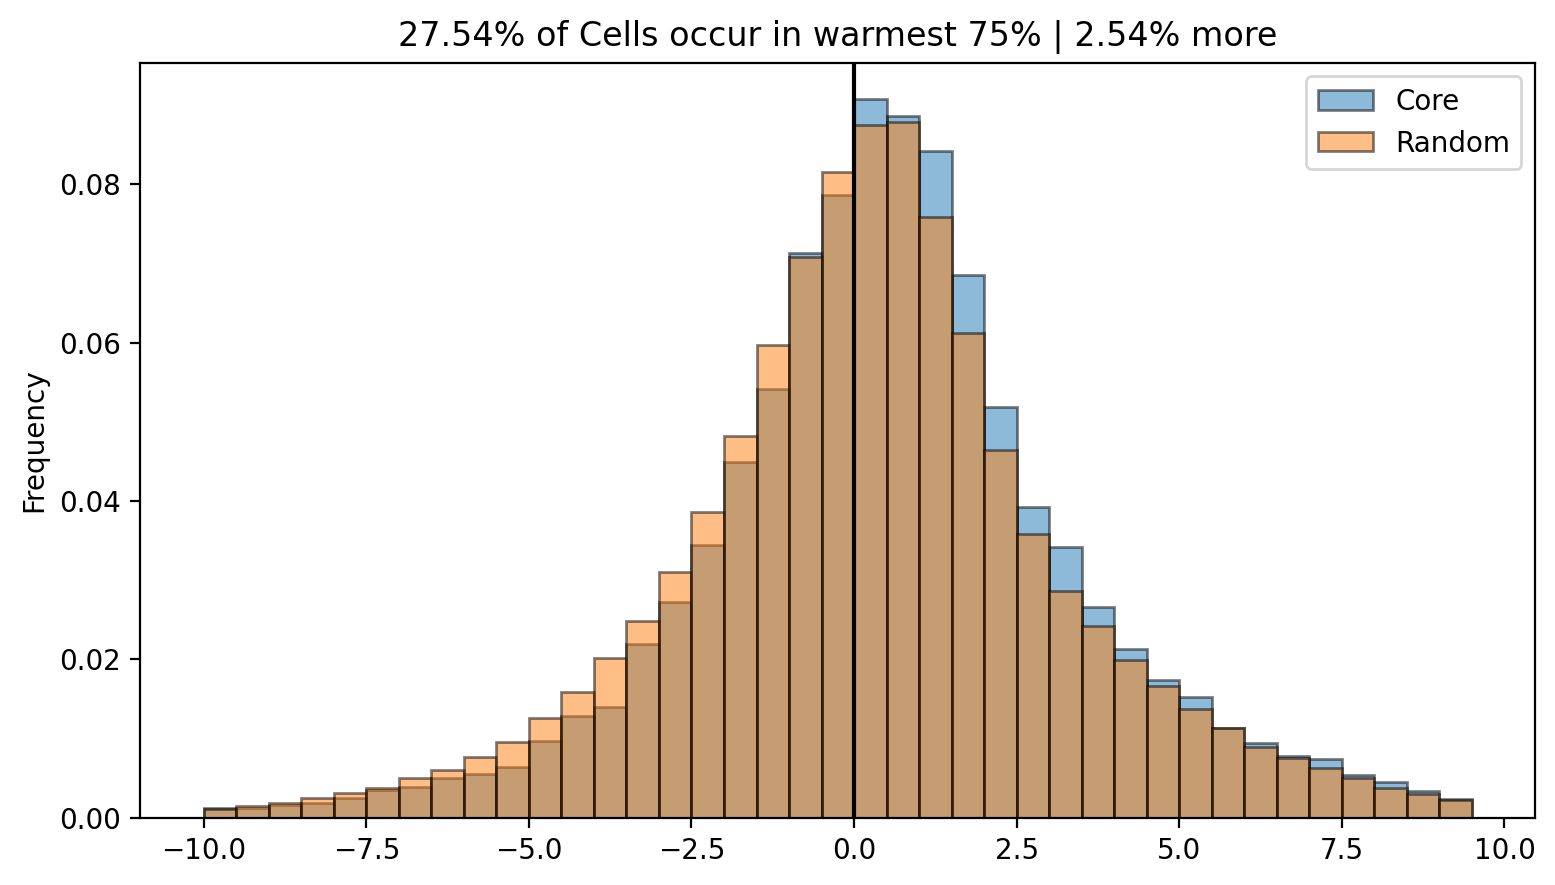

In [80]:
    cinput = np.array(dic['amsr'][0])
    rinput = np.array(dic['ramsr'][0])
    cinput = cinput[np.isfinite(cinput)]
    rinput = rinput[np.isfinite(rinput)]

    nbpoint, pointcount, bins = u_stat.histo_frequency(cinput, bins=np.arange(-10,10,0.5))
    nball, allcount, bins = u_stat.histo_frequency(rinput, bins=np.arange(-10, 10, 0.5))
    print(bins)
    bin_centre = bins[0:-1] + ((bins[1::] - bins[0:-1]) / 2)
    bin_edge = bins[0:-1]
    width = bins[1::] - bins[0:-1]

    f = plt.figure(figsize=(9,5), dpi=200)
    ax = f.add_subplot(111)

    ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
    ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)
    plt.ylabel('Frequency')
    stri = (np.sum(cinput >= np.percentile(rinput, 75)) / cinput.size * 100).round(2)
    #ipdb.set_trace()
    plt.title(str(stri)+'% of Cells occur in warmest 75% | '+ str(np.round(stri-25,2))+'% more')
    plt.legend()

    stri = (np.sum(cinput >= np.percentile(rinput, 50)) / cinput.size * 100).round(2)
    print(str(stri) + '% of Cells occur in warmest half')
    
    plt.axvline(0, color='k')
    #f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_prob.png')

In [81]:
from scipy.stats import norm
# best fit of data
(mupoint, sigmapoint) = norm.fit(point)
(muall, sigmaall) = norm.fit(all)

# add a 'best fit' line
ypoint = norm.pdf( bins, mupoint, sigmapoint)
yall = norm.pdf(bins, muall, sigmaall)

# add a 'best fit' line
cypoint = norm.cdf( bins, mupoint, sigmapoint)
cyall = norm.cdf(bins, muall, sigmaall)

print('Core', norm.pdf(0,mupoint,sigmapoint))
print('Random', norm.pdf(0,muall,sigmaall))


Core 0.1284242715166
Random 0.12649947017315702


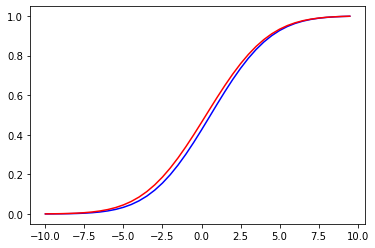

In [82]:
plt.plot(bins,cypoint, 'b')
plt.plot(bins, cyall, 'r')

54.27% of Cells occur in warmest half Enhancement:8.54%


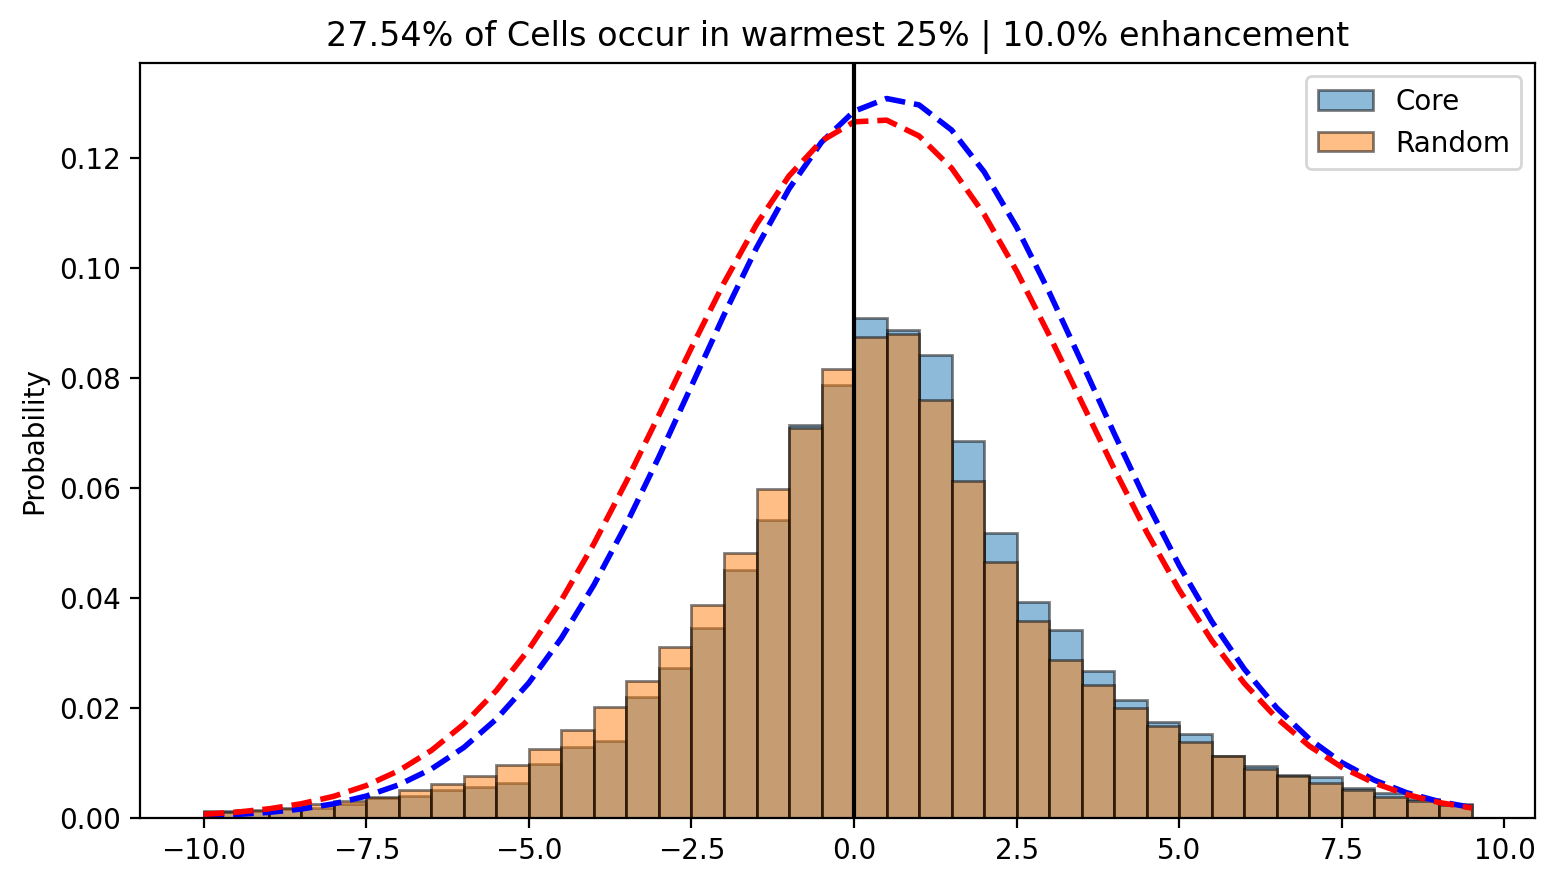

In [83]:
f = plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)

ax.bar(bin_edge, nbpoint, label='Core', edgecolor='k', alpha=0.5, align='edge', width=width)
ax.bar(bin_edge, nball, label='Random', edgecolor='k', alpha=0.5, align='edge', width=width)

plt.plot(bins, ypoint, 'b--', linewidth=2)
plt.plot(bins, yall, 'r--', linewidth=2)

plt.ylabel('Probability')
stri = (np.sum(cinput >= np.percentile(rinput, 75)) / cinput.size * 100).round(2)
enh = (stri-25)/25*100
plt.title(str(stri)+'% of Cells occur in warmest 25% | '+ str(np.round(enh))+'% enhancement')
plt.legend()

stri = (np.sum(cinput >= np.percentile(rinput, 50)) / cinput.size * 100).round(2)
enh = (stri-50)/50*100
print(str(stri) + '% of Cells occur in warmest half', 'Enhancement:'+str(np.round(enh,2))+'%')

plt.axvline(0, color='k')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_prob_fit.png')

In [86]:
def calc_prob(x, mu_core, mu_random, sigma_core, sigma_random):
    
    corep = norm.pdf(x,mu_core,sigma_core)
    randomp = norm.pdf(x,mu_random,sigma_random)
    
    corec = norm.cdf(x,mu_core,sigma_core)
    randomc = norm.cdf(x,mu_random,sigma_random)
    
    out_pdf = (corep - randomp)/randomp

    prob_factor = 1+out_pdf

    return out_pdf, prob_factor

In [120]:
calc_prob(-7, mupoint, muall, sigmapoint, sigmaall)

(-0.3020855327843165, 0.6979144672156835)

In [88]:
prob = []
factor = []
for b in bins:
    tb, fac = calc_prob(b, mupoint, muall, sigmapoint, sigmaall)
    prob.append(tb)
    factor.append(fac)

In [89]:
factor

[0.5429804208202993,
 0.5683160206387676,
 0.5939381269227741,
 0.6197807573264266,
 0.6457739898816839,
 0.6718442217354175,
 0.6979144672156835,
 0.7239046941289105,
 0.7497321967338546,
 0.7753120033829137,
 0.800557316373255,
 0.8253799811153799,
 0.8496909813119409,
 0.8734009564510489,
 0.896420737562329,
 0.918661896866434,
 0.9400373066751705,
 0.9604617026748423,
 0.9798522465542642,
 0.9981290828248622,
 1.015215884626301,
 1.0310403833192208,
 1.0455348767381514,
 1.0586367111127224,
 1.0702887318632146,
 1.080439698735622,
 1.0890446610590867,
 1.0960652892812877,
 1.1014701593606755,
 1.1052349870631322,
 1.1073428097186664,
 1.10778411353462,
 1.1065569051282766,
 1.1036667265262807,
 1.0991266134729365,
 1.0929569974862432,
 1.085185552691449,
 1.0758469890387736,
 1.0649827940673566,
 1.05264092590363]

Text(0.5, 1.0, 'Probability factor (1-P)')

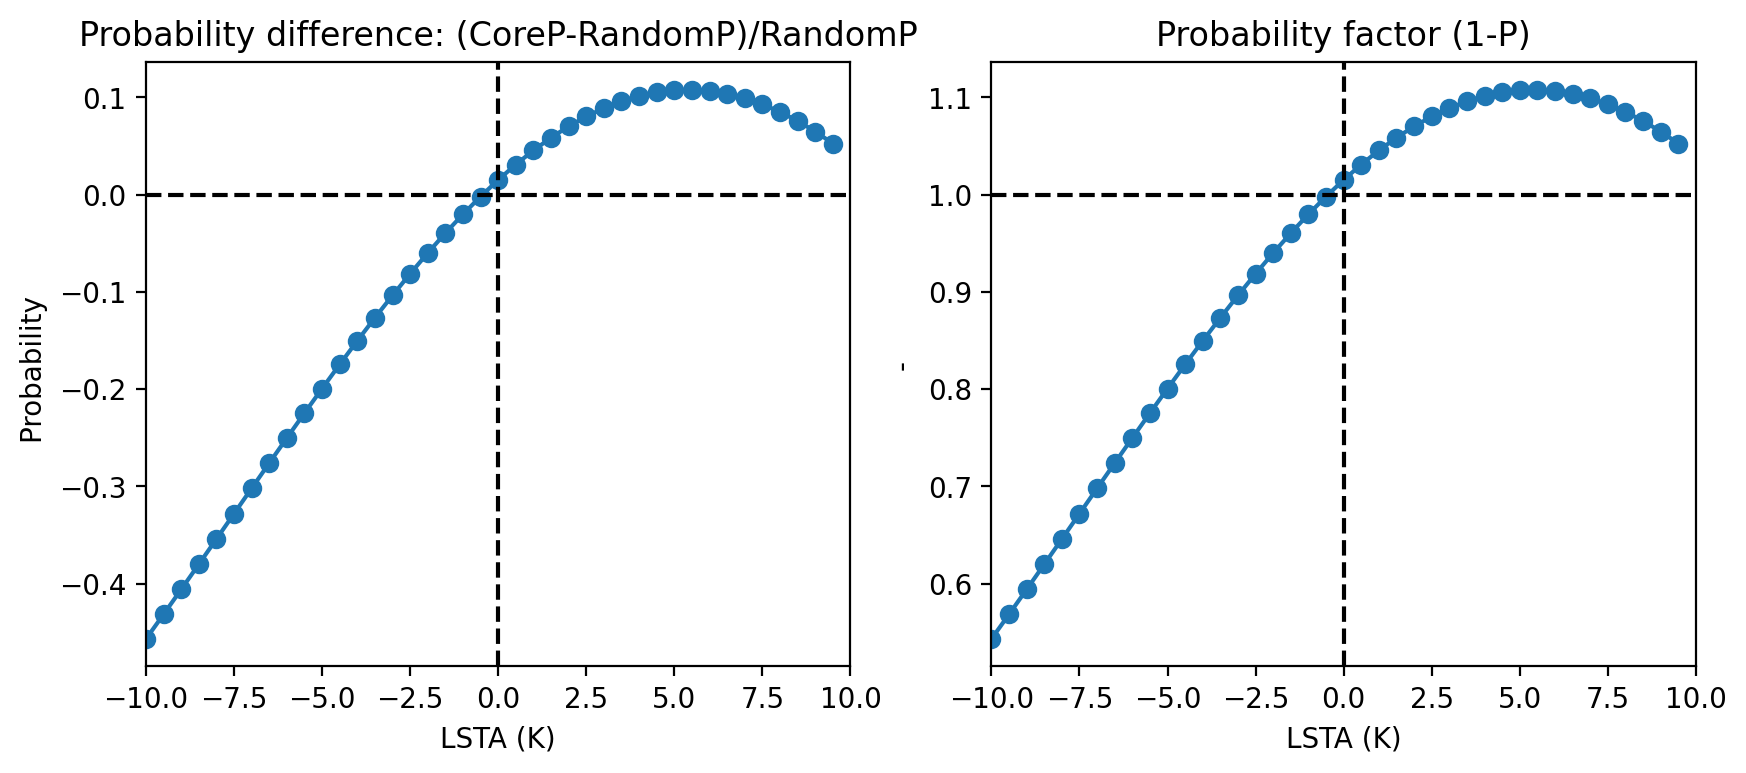

In [90]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(121)
plt.plot(bins,np.array(prob), marker='o')
plt.ylabel('Probability ')
plt.axhline(0,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability difference: (CoreP-RandomP)/RandomP')

ax = f.add_subplot(122)
plt.plot(bins,np.array(factor), marker='o')
plt.ylabel('-')
plt.axhline(1,color='k', linestyle='dashed')
plt.axvline(0,color='k', linestyle='dashed')
plt.xlim(-10,10)
plt.xlabel('LSTA (K)')
plt.title('Probability factor (1-P)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/p_change.png')

In [106]:
testlsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200806191700.nc')

In [107]:
testlsta.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (lat: 594, lon: 1410, scales: 11)
Coordinates:
  * lat      (lat) float64 4.0 4.027 4.054 4.081 ... 19.97 19.99 20.02 20.05
  * lon      (lon) float64 -18.0 -17.97 -17.95 -17.92 ... 19.92 19.94 19.97
  * scales   (scales) float64 20.0 26.39 34.82 45.95 ... 139.3 183.8 242.5 320.0
Data variables:
    lsta     (lat, lon) int16 ...
    NbSlot   (lat, lon) int8 ...
    wavelet  (scales, lat, lon) int16 ...>

In [108]:
testlsta = testlsta['lsta'].sel(lat=slice(10,20), lon=slice(-17.2,-2))/100
testlsta.values[testlsta.values==0]=np.nan


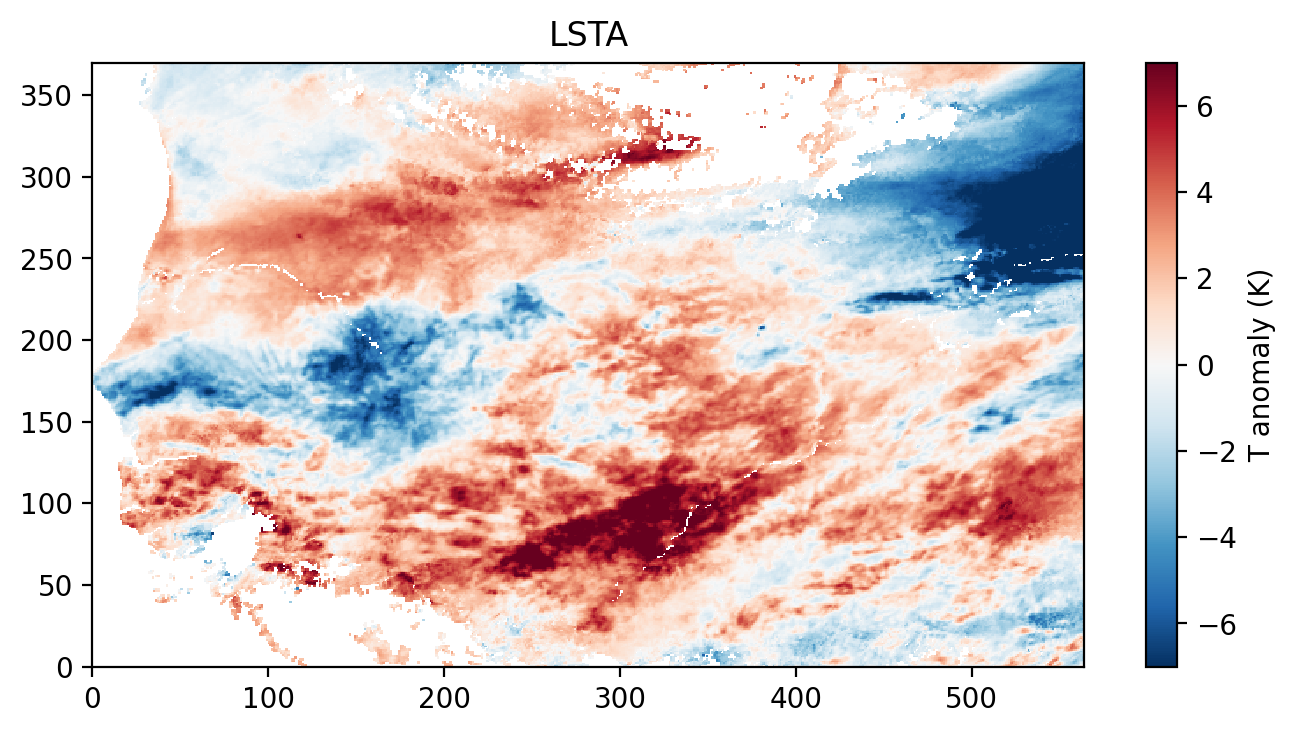

In [119]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.pcolormesh(testlsta, cmap='RdBu_r', vmin=-7, vmax=7)
plt.title('LSTA')
cbar = plt.colorbar()
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [111]:
probability_map = np.zeros_like(testlsta.values)*np.nan

In [114]:
for i in range(probability_map.shape[0]):
    for j in range(probability_map.shape[1]):
        p, fac = calc_prob(testlsta.values[i,j], mupoint, muall, sigmapoint, sigmaall)
        probability_map[i,j] = fac
        

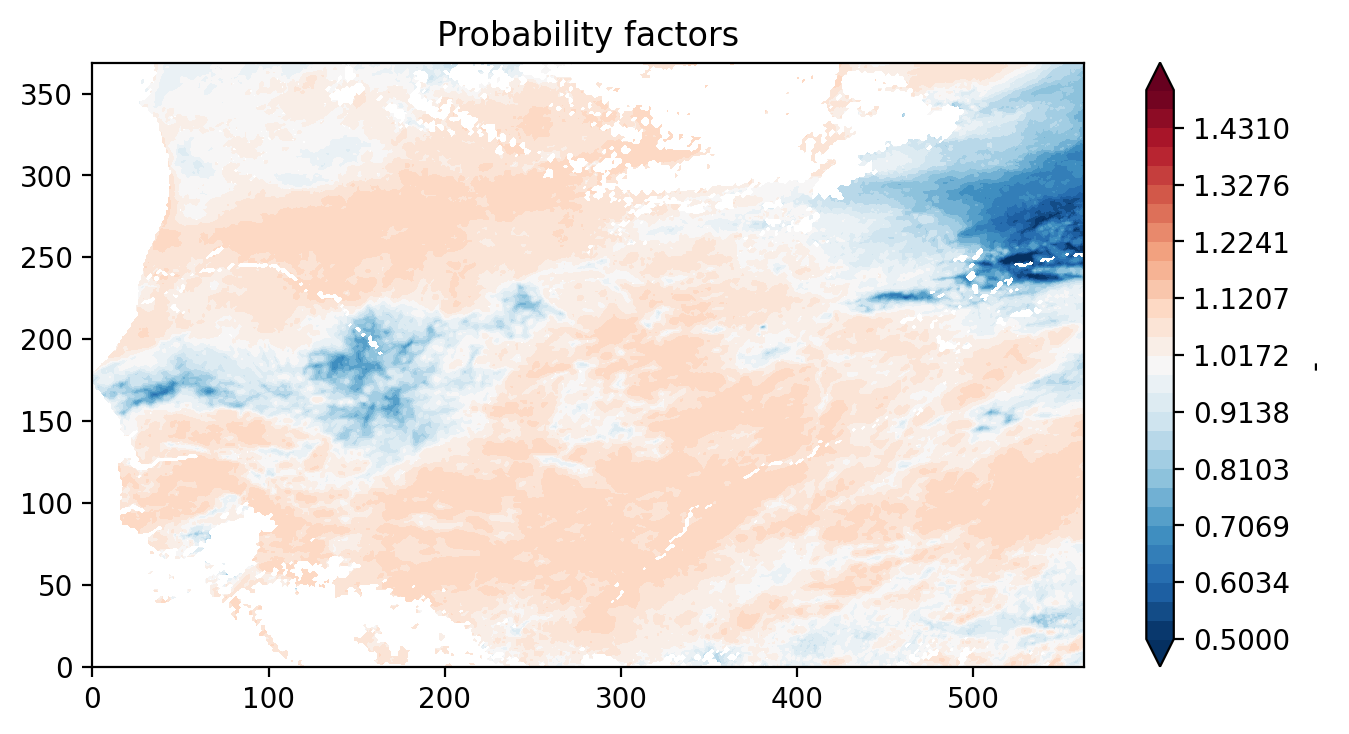

In [124]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(0.5,1.5,30), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()
cbar.set_label('-')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

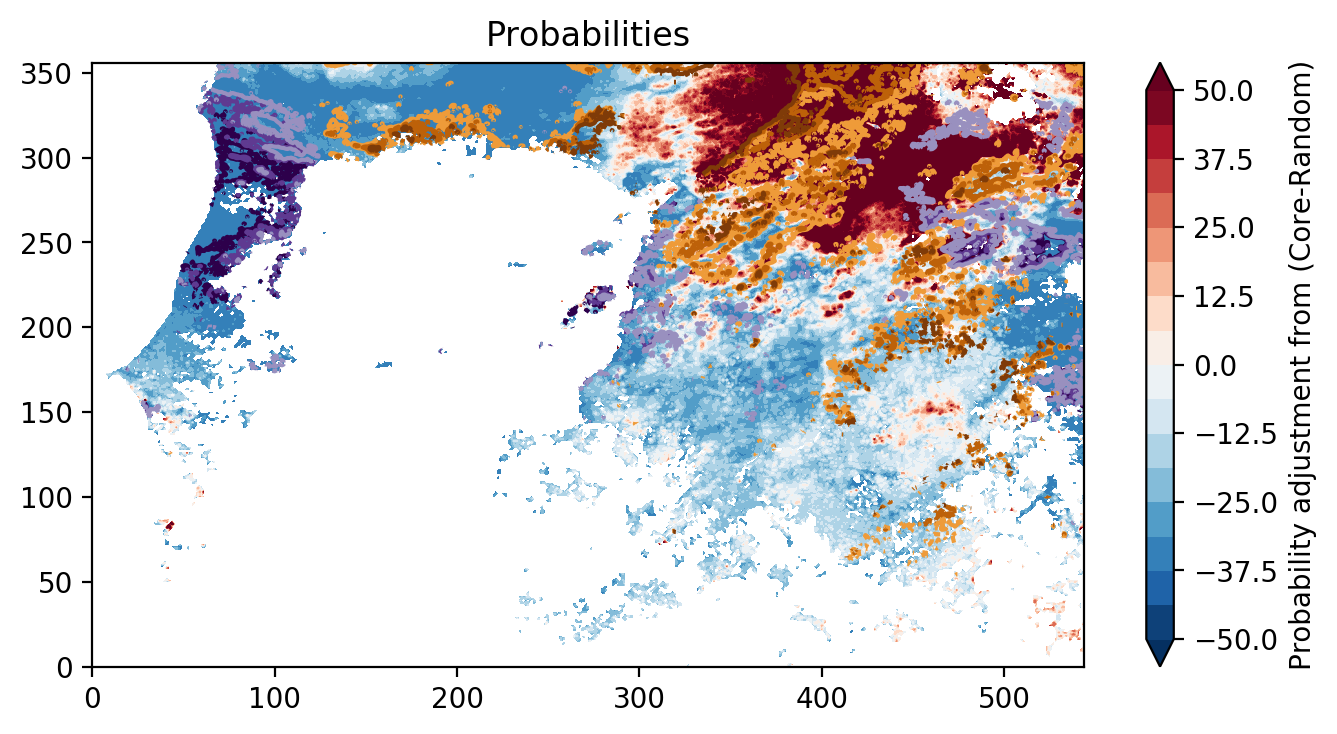

In [304]:
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(probability_map, cmap='RdBu_r',levels=np.linspace(-50,50,17), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
cbar = plt.colorbar()
plt.contour(testlsta1['lsta'].values-testlsta['lsta'].values, cmap='PuOr_r', levels=[-8,-6,-4,4,6,8], extend='both')

plt.title('Probabilities')

cbar.set_label('Probability adjustment from (Core-Random)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map_probability.png')

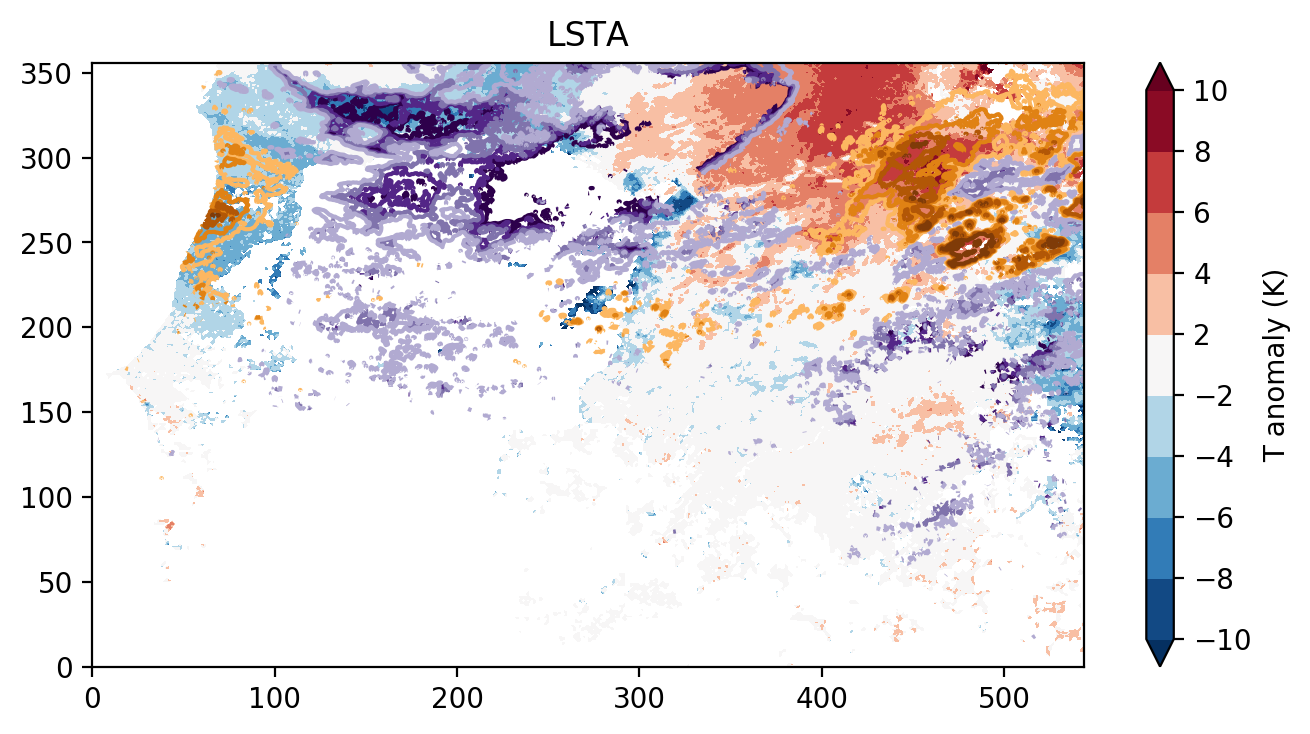

In [303]:
testlsta1 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_201208251700.nc')
testlsta1 = testlsta1.sel(lat=slice(10,20), lon=slice(-17.2,-2))
f=plt.figure(figsize=(8,4), dpi=200)
plt.contourf(testlsta1['lsta'].values, cmap='RdBu_r', levels=[-10,-8,-6,-4,-2,2,4,6,8,10], extend='both')

plt.title('LSTA')
cbar = plt.colorbar()
plt.contour(testlsta['lsta'].values, cmap='PuOr_r', levels=[-10,-8,-6,-4,4,6,8,10])
cbar.set_label('T anomaly (K)')
#f.savefig('/home/ck/DIR/cornkle/figs/NFLICS/plots/lsta/example_day_map.png')

In [311]:
lpath = cnst.elements_drive+'/Africa/WestAfrica/NFLICS/LSTA_2004-2015/netcdf/'
testlsta = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200409131700.nc')
testlsta1 = xr.open_dataset(lpath + 'HDF5_LSASAF_ANOM_MSG_LST_MSG-Disk_200409141700.nc')

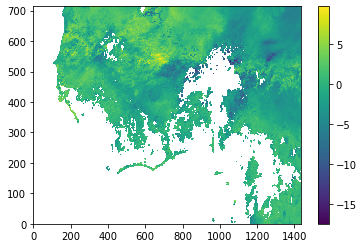

In [312]:
plt.pcolormesh(testlsta['lsta'])
plt.colorbar()

In [313]:
from NFLICS import LSTA_probability_calculation as pcalc

In [314]:
lsta_pval = pcalc.run(16,testlsta['lsta'].values)

In [315]:
lsta_pval

array([[       nan,        nan,        nan, ..., 1.08854711, 1.06699232,
        1.08186395],
       [       nan,        nan,        nan, ..., 1.08557099, 1.08015342,
        1.08049681],
       [       nan,        nan,        nan, ..., 1.07243557, 1.0838955 ,
        1.08049681],
       ...,
       [       nan,        nan,        nan, ..., 0.75755802, 0.7495688 ,
        0.7469416 ],
       [       nan,        nan,        nan, ..., 0.75274558, 0.74485343,
        0.74851569],
       [       nan,        nan,        nan, ..., 0.75274558, 0.74020088,
        0.74020088]])

Text(0.5, 1.0, 'Day+1')

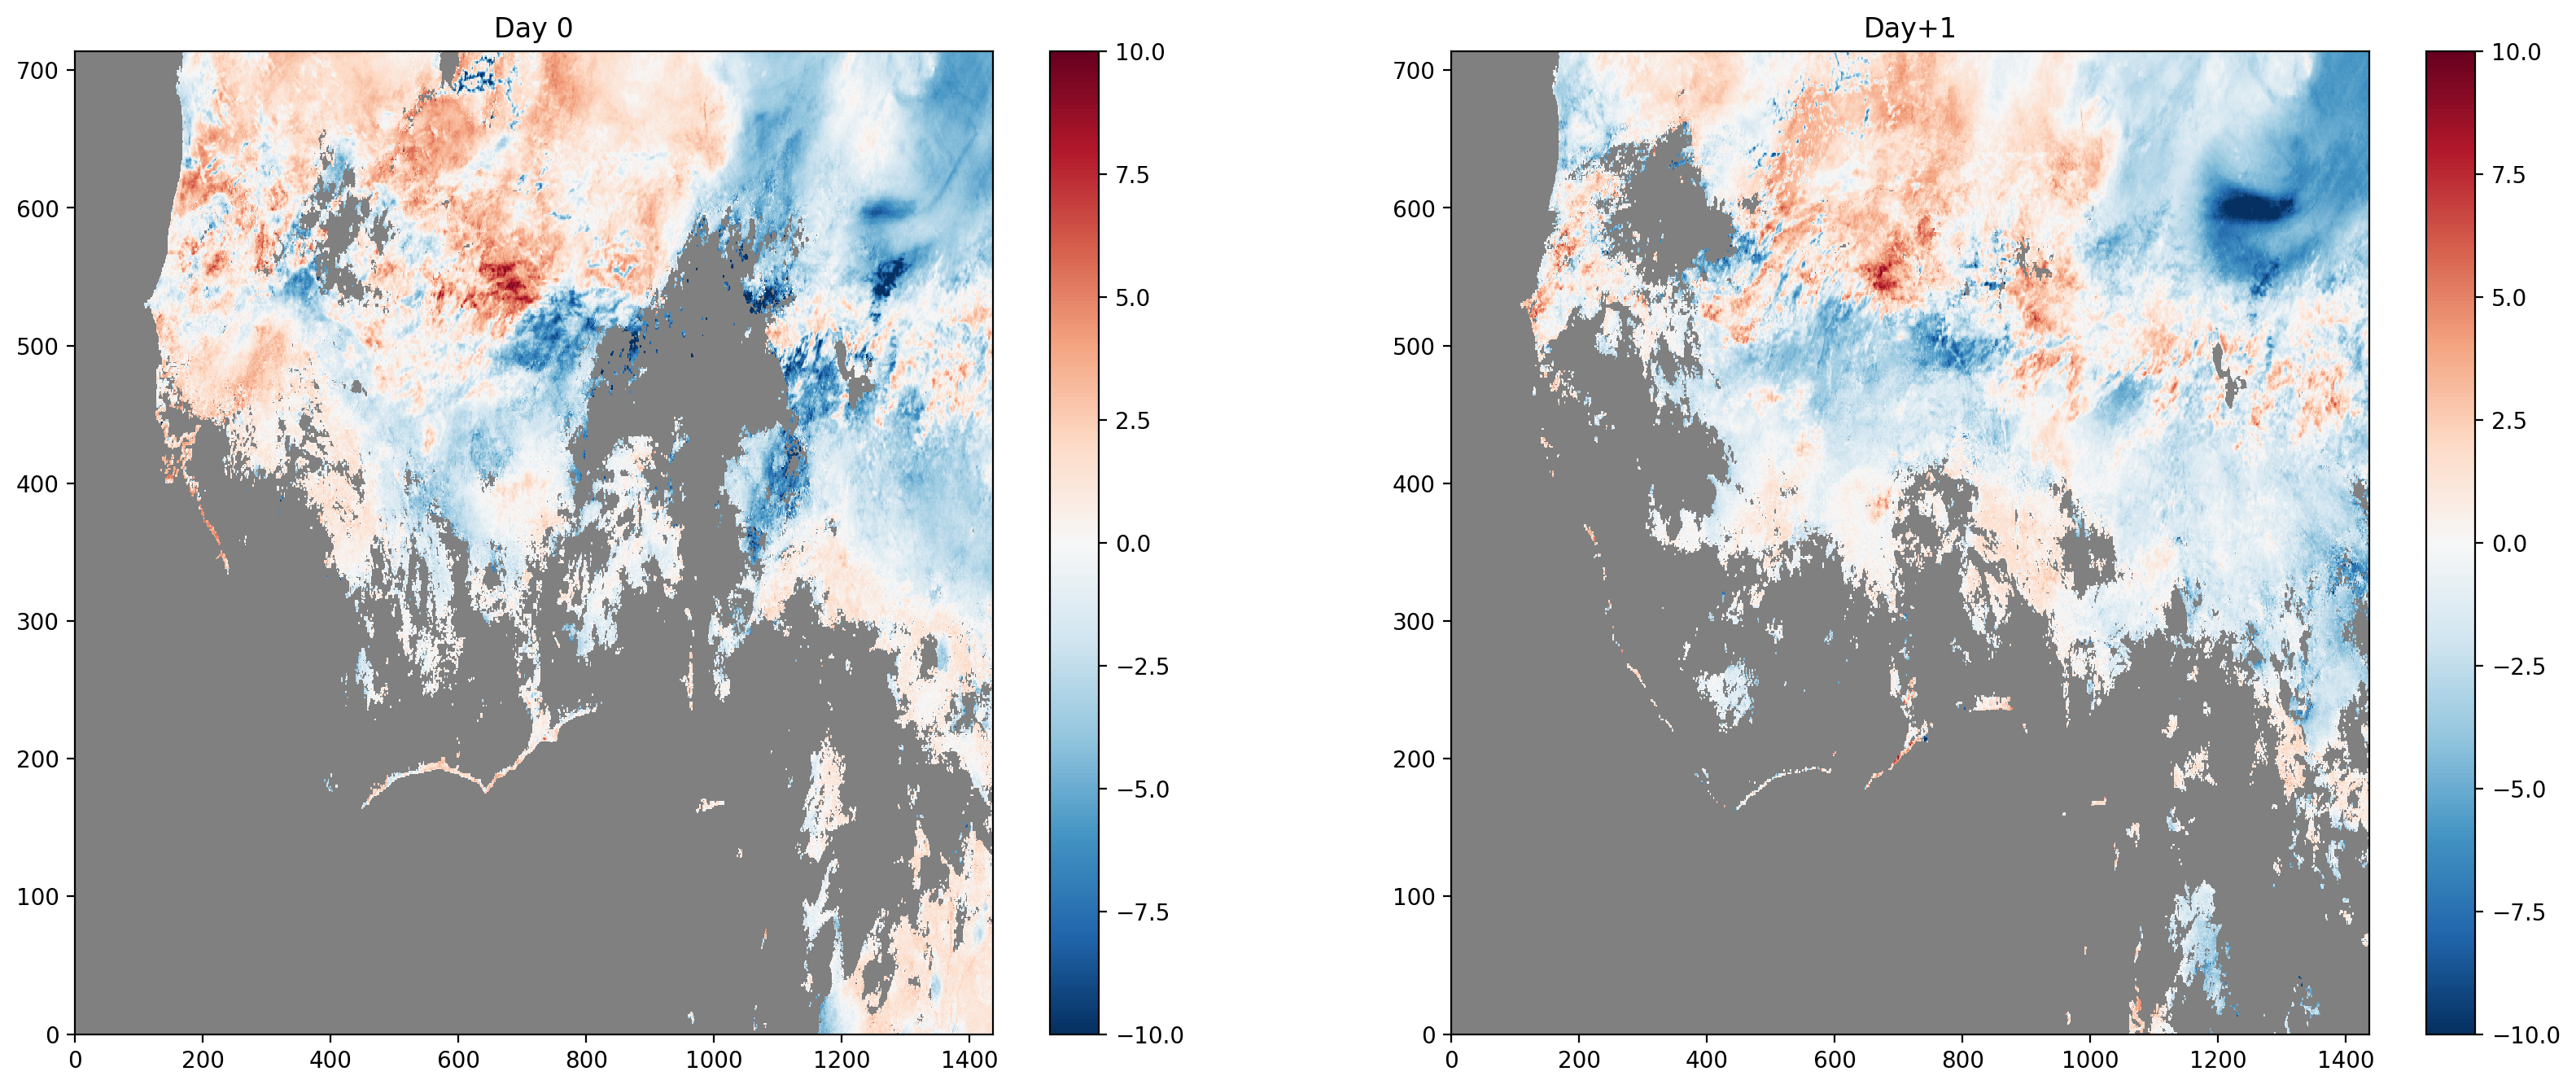

In [316]:
f = plt.figure(figsize=(20,8), dpi=200)
ax = f.add_subplot(121)
ax.set_facecolor('grey')
plt.pcolormesh(testlsta['lsta'].values, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()
plt.title('Day 0')

ax = f.add_subplot(122)
ax.set_facecolor('grey')
plt.pcolormesh(testlsta1['lsta'].values, cmap='RdBu_r', vmin=-10, vmax=10)
#plt.contour(lsta_pval, levels=[1.15,1.2], cmap='viridis_r')
plt.colorbar()
plt.title('Day+1')

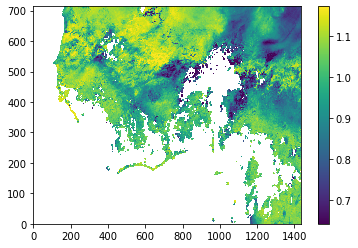

In [317]:
plt.pcolormesh(lsta_pval)
plt.colorbar()

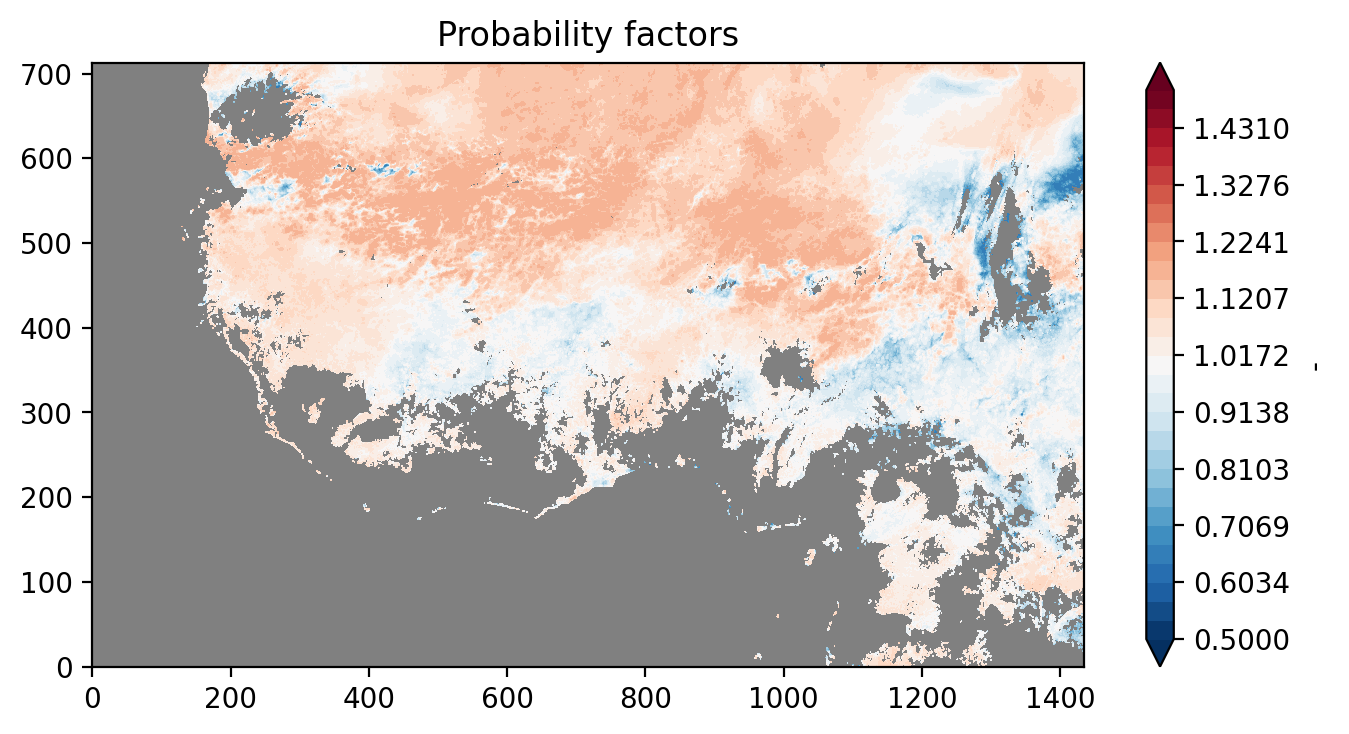

In [297]:
f=plt.figure(figsize=(8,4), dpi=200)
ax = f.add_subplot(111)
ax.set_facecolor('grey')
plt.contourf(lsta_pval, cmap='RdBu_r',levels=np.linspace(0.5,1.5,30), extend='both')
#plt.contour(testlsta['lsta'], cmap='RdBu_r', vmin=-10, vmax=10)
plt.title('Probability factors')
cbar = plt.colorbar()
cbar.set_label('-')